<a href="https://colab.research.google.com/github/jlhitt1993/LearningCatalyst/blob/main/HOR_screening_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook needs to find the appropriate data files of catalyst screening results and element properties. The following blocks of code may need to be modified slightly in order to find the data and python packages on each computer. 

## Mount drive

In [ ]:
# Connect notebook to google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install packages

In [ ]:
# install packages to google colab
!pip install dtreeviz
!pip install python-ternary
!pip install orca
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 8.1 MB/s 
     |████████████████████████████████| 1.1 MB 59.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=72fe542717f723a4c8280b6cf85678513e64b3fa1cb8ff1433ba9b3b59f97fd3
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=39c3b34640243492626d9ad6f58f137cd121cf688e0c20218aa464af22b1d9a6
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec7

## import packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
import seaborn as sb
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, ShuffleSplit, cross_validate
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.linear_model import LinearRegression, ARDRegression, HuberRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
import sklearn.inspection as inspection
from dtreeviz.trees import dtreeviz
import ternary
from ternary.helpers import simplex_iterator
import random
import plotly.express as px
from operator import itemgetter
import networkx as nx
import string
from math import ceil
from matplotlib.ticker import MultipleLocator
from umap import UMAP
!pip install "notebook>=5.3" "ipywidgets>=7.2"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 20.6 MB/s 


## Reading data



In [ ]:
# Read the databases into a pandas dataframe and drop columns with missing values
df2 = pd.read_excel('G:/My Drive/Alkaline HOR/Screening/Db with no amine.xlsx', skiprows=None).dropna(axis=0,how="all")
#df2 = pd.read_excel('drive/My Drive/Alkaline HOR/Screening/Db with no amine.xlsx', skiprows=None).dropna(axis=0,how="all")
df2 = df2.dropna(axis=1,how="all")
df2 = df2.dropna(axis=0,how="any")
df2['Onset potential H2 Ag/AgCl'] = df2['Onset potential H2 Ag/AgCl'].replace(0.9,0.8)
db = pd.read_excel('G:/My Drive/CO2/ML/Database of elements.xlsx',index_col='Element')
#db = pd.read_excel('drive/My Drive/CO2/ML/Database of elements.xlsx',index_col='Element')
df2

,Sample ID,Percent A,Percent B,Percent C,Onset potential H2 Ag/AgCl,Element A atomic #,Element B atomic #,Element C atomic #,Electronegativity of A,Electronegativity of B,...,Lattice spacing C,H binding A,H binding B,H binding C,M-O bond strength A,M-O bond strength B,M-O bond strength C,OH binding A,OH binding B,OH binding C
0,Ni0Pt10Pd0,0.0,1.0,0.0,-0.10,28,78,46,1.91,2.28,...,2.75,-2.70,-2.5,-2.8,586.40,606.5,466.1,-2.0,-2.05,-2.10
1,Ni0Pt9Pd1,0.0,0.9,0.1,-0.25,28,78,46,1.91,2.28,...,2.75,-2.70,-2.5,-2.8,586.40,606.5,466.1,-2.0,-2.05,-2.10
2,Ni0Pt8Pd2,0.0,0.8,0.2,-0.20,28,78,46,1.91,2.28,...,2.75,-2.70,-2.5,-2.8,586.40,606.5,466.1,-2.0,-2.05,-2.10
3,Ni0Pt7Pd3,0.0,0.7,0.3,-0.15,28,78,46,1.91,2.28,...,2.75,-2.70,-2.5,-2.8,586.40,606.5,466.1,-2.0,-2.05,-2.10
4,Ni0Pt6Pd4,0.0,0.6,0.4,-0.20,28,78,46,1.91,2.28,...,2.75,-2.70,-2.5,-2.8,586.40,606.5,466.1,-2.0,-2.05,-2.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,Sn8Pd1Pt1,0.8,0.1,0.1,0.00,50,46,78,1.96,2.20,...,2.77,-1.17,-2.8,-2.5,870.48,466.1,606.5,-0.4,-2.10,-2.05
1580,Sn8Pd0Pt2,0.8,0.0,0.2,0.80,50,46,78,1.96,2.20,...,2.77,-1.17,-2.8,-2.5,870.48,466.1,606.5,-0.4,-2.10,-2.05
1581,Sn9Pd1Pt0,0.9,0.1,0.0,0.80,50,46,78,1.96,2.20,...,2.77,-1.17,-2.8,-2.5,870.48,466.1,606.5,-0.4,-2.10,-2.05
1582,Sn9Pd0Pt1,0.9,0.0,0.1,0.80,50,46,78,1.96,2.20,...,2.77,-1.17,-2.8,-2.5,870.48,466.1,606.5,-0.4,-2.10,-2.05


## One-hot encoding of atomic number

In [ ]:
# One-hot encoding of categorical features
def one_hot(Df2):
  Elements = np.concatenate([Df2["Element A atomic #"].unique(), Df2["Element B atomic #"].unique(),
                            Df2["Element C atomic #"].unique()])
  #unique = np.unique(Elements)
  #print(unique)
  num_rows = len(Df2)
  Ais78 = np.zeros((num_rows,))
  Ais46 = np.zeros((num_rows,))
  Ais27 = np.zeros((num_rows,))
  Ais26 = np.zeros((num_rows,))
  Ais25 = np.zeros((num_rows,))
  Ais77 = np.zeros((num_rows,))
  Ais28 = np.zeros((num_rows,))
  Ais29 = np.zeros((num_rows,))
  Ais47 = np.zeros((num_rows,))
  Ais79 = np.zeros((num_rows,))
  Ais45 = np.zeros((num_rows,))
  Ais24 = np.zeros((num_rows,))
  Ais50 = np.zeros((num_rows,))
  Ais82 = np.zeros((num_rows,))
  Ais80 = np.zeros((num_rows,))

  Bis78 = np.zeros((num_rows,))
  Bis46 = np.zeros((num_rows,))
  Bis27 = np.zeros((num_rows,))
  Bis26 = np.zeros((num_rows,))
  Bis25 = np.zeros((num_rows,))
  Bis77 = np.zeros((num_rows,))
  Bis28 = np.zeros((num_rows,))
  Bis29 = np.zeros((num_rows,))
  Bis47 = np.zeros((num_rows,))
  Bis79 = np.zeros((num_rows,))
  Bis45 = np.zeros((num_rows,))
  Bis24 = np.zeros((num_rows,))
  Bis50 = np.zeros((num_rows,))
  Bis82 = np.zeros((num_rows,))
  Bis80 = np.zeros((num_rows,))

  Cis78 = np.zeros((num_rows,))
  Cis46 = np.zeros((num_rows,))
  Cis27 = np.zeros((num_rows,))
  Cis26 = np.zeros((num_rows,))
  Cis25 = np.zeros((num_rows,))
  Cis77 = np.zeros((num_rows,))
  Cis28 = np.zeros((num_rows,))
  Cis29 = np.zeros((num_rows,))
  Cis47 = np.zeros((num_rows,))
  Cis79 = np.zeros((num_rows,))
  Cis45 = np.zeros((num_rows,))
  Cis24 = np.zeros((num_rows,))
  Cis50 = np.zeros((num_rows,))
  Cis82 = np.zeros((num_rows,))
  Cis80 = np.zeros((num_rows,))

  Aisseventyeight = np.where(Df2["Element A atomic #"] == 78.0)
  Aisfourtysix = np.where(Df2["Element A atomic #"] == 46.0)
  Aistwentyseven = np.where(Df2["Element A atomic #"] == 27.0)
  Aistwentysix = np.where(Df2["Element A atomic #"] == 26.0)
  Aistwentyfive = np.where(Df2["Element A atomic #"] == 25.0)
  Aisseventyseven = np.where(Df2["Element A atomic #"] == 77.0)
  Aistwentyeight = np.where(Df2["Element A atomic #"] == 28.0)
  Aistwentynine = np.where(Df2["Element A atomic #"] == 29.0)
  Aisfourtyseven = np.where(Df2["Element A atomic #"] == 47.0)
  Aisseventynine = np.where(Df2["Element A atomic #"] == 79.0)
  Aisfourtyfive = np.where(Df2["Element A atomic #"] == 45.0)
  Aistwentyfour = np.where(Df2["Element A atomic #"] == 24.0)
  Aisfifty = np.where(Df2["Element A atomic #"] == 50.0)
  Aiseightytwo = np.where(Df2["Element A atomic #"] == 82.0)
  Aiseighty = np.where(Df2["Element A atomic #"] == 80.0)

  Bisseventyeight = np.where(Df2["Element B atomic #"] == 78.0)
  Bisfourtysix = np.where(Df2["Element B atomic #"] == 46.0)
  Bistwentyseven = np.where(Df2["Element B atomic #"] == 27.0)
  Bistwentysix = np.where(Df2["Element B atomic #"] == 26.0)
  Bistwentyfive = np.where(Df2["Element B atomic #"] == 25.0)
  Bisseventyseven = np.where(Df2["Element B atomic #"] == 77.0)
  Bistwentyeight = np.where(Df2["Element B atomic #"] == 28.0)
  Bistwentynine = np.where(Df2["Element B atomic #"] == 29.0)
  Bisfourtyseven = np.where(Df2["Element B atomic #"] == 47.0)
  Bisseventynine = np.where(Df2["Element B atomic #"] == 79.0)
  Bisfourtyfive = np.where(Df2["Element B atomic #"] == 45.0)
  Bistwentyfour = np.where(Df2["Element B atomic #"] == 24.0)
  Bisfifty = np.where(Df2["Element B atomic #"] == 50.0)
  Biseightytwo = np.where(Df2["Element B atomic #"] == 82.0)
  Biseighty = np.where(Df2["Element B atomic #"] == 80.0)

  Cisseventyeight = np.where(Df2["Element C atomic #"] == 78.0)
  Cisfourtysix = np.where(Df2["Element C atomic #"] == 46.0)
  Cistwentyseven = np.where(Df2["Element C atomic #"] == 27.0)
  Cistwentysix = np.where(Df2["Element C atomic #"] == 26.0)
  Cistwentyfive = np.where(Df2["Element C atomic #"] == 25.0)
  Cisseventyseven = np.where(Df2["Element C atomic #"] == 77.0)
  Cistwentyeight = np.where(Df2["Element C atomic #"] == 28.0)
  Cistwentynine = np.where(Df2["Element C atomic #"] == 29.0)
  Cisfourtyseven = np.where(Df2["Element C atomic #"] == 47.0)
  Cisseventynine = np.where(Df2["Element C atomic #"] == 79.0)
  Cisfourtyfive = np.where(Df2["Element C atomic #"] == 45.0)
  Cistwentyfour = np.where(Df2["Element C atomic #"] == 24.0)
  Cisfifty = np.where(Df2["Element C atomic #"] == 50.0)
  Ciseightytwo = np.where(Df2["Element C atomic #"] == 82.0)
  Ciseighty = np.where(Df2["Element C atomic #"] == 80.0)

  Ais78[Aisseventyeight[0]] = 1
  Ais46[Aisfourtysix[0]] = 1
  Ais27[Aistwentyseven[0]] = 1
  Ais26[Aistwentysix[0]] =1
  Ais25[Aistwentyfive[0]] = 1
  Ais77[Aisseventyseven[0]] = 1
  Ais28[Aistwentyeight[0]] = 1
  Ais29[Aistwentynine[0]] = 1
  Ais47[Aisfourtyseven[0]] =1
  Ais79[Aisseventynine[0]] = 1
  Ais45[Aisfourtyfive[0]] = 1
  Ais24[Aistwentyfour[0]] =1
  Ais50[Aisfifty[0]] = 1
  Ais82[Aiseightytwo[0]] = 1
  Ais80[Aiseighty[0]] = 1

  Bis78[Bisseventyeight[0]] = 1
  Bis46[Bisfourtysix[0]] = 1
  Bis27[Bistwentyseven[0]] = 1
  Bis26[Bistwentysix[0]] =1
  Bis25[Bistwentyfive[0]] = 1
  Bis77[Bisseventyseven[0]] = 1
  Bis28[Bistwentyeight[0]] = 1
  Bis29[Bistwentynine[0]] = 1
  Bis47[Bisfourtyseven[0]] = 1
  Bis79[Bisseventynine[0]] = 1
  Bis45[Bisfourtyfive[0]] = 1
  Bis24[Bistwentyfour[0]] =1
  Bis50[Bisfifty[0]] = 1
  Bis82[Biseightytwo[0]] = 1
  Bis80[Biseighty[0]] = 1

  Cis78[Cisseventyeight[0]] = 1
  Cis46[Cisfourtysix[0]] = 1
  Cis27[Cistwentyseven[0]] = 1
  Cis26[Cistwentysix[0]] =1
  Cis25[Cistwentyfive[0]] = 1
  Cis77[Cisseventyseven[0]] = 1
  Cis28[Cistwentyeight[0]] = 1
  Cis29[Cistwentynine[0]] = 1
  Cis47[Cisfourtyseven[0]] = 1
  Cis79[Cisseventynine[0]] = 1
  Cis45[Cisfourtyfive[0]] = 1
  Cis24[Cistwentyfour[0]] =1
  Cis50[Cisfifty[0]] = 1
  Cis82[Ciseightytwo[0]] = 1
  Cis80[Ciseighty[0]] = 1

  Df2["Ais78"] = Ais78
  Df2["Ais46"] = Ais46
  Df2["Ais27"] = Ais27
  Df2["Ais26"] = Ais26
  Df2["Ais25"] = Ais25
  Df2["Ais77"] = Ais77
  Df2["Ais28"] = Ais28
  Df2["Ais29"] = Ais29
  Df2["Ais47"] = Ais47
  Df2["Ais79"] = Ais79
  Df2["Ais45"] = Ais45
  Df2["Ais24"] = Ais24
  Df2["Ais50"] = Ais50
  Df2["Ais82"] = Ais82
  Df2["Ais80"] = Ais80

  Df2["Bis78"] = Bis78
  Df2["Bis46"] = Bis46
  Df2["Bis27"] = Bis27
  Df2["Bis26"] = Bis26
  Df2["Bis25"] = Bis25
  Df2["Bis77"] = Bis77
  Df2["Bis28"] = Bis28
  Df2["Bis29"] = Bis29
  Df2["Bis47"] = Bis47
  Df2["Bis79"] = Bis79
  Df2["Bis45"] = Bis45
  Df2["Bis24"] = Bis24
  Df2["Bis50"] = Bis50
  Df2["Bis82"] = Bis82
  Df2["Bis80"] = Bis80

  Df2["Cis78"] = Cis78
  Df2["Cis46"] = Cis46
  Df2["Cis27"] = Cis27
  Df2["Cis26"] = Cis26
  Df2["Cis25"] = Cis25
  Df2["Cis77"] = Cis77
  Df2["Cis28"] = Cis28
  Df2["Cis29"] = Cis29
  Df2["Cis47"] = Cis47
  Df2["Cis79"] = Cis79
  Df2["Cis45"] = Cis45
  Df2["Cis24"] = Cis24
  Df2["Cis50"] = Cis50
  Df2["Cis82"] = Cis82
  Df2["Cis80"] = Cis80


  Aisd9s1 = np.zeros((num_rows,))
  Aisd10s0 = np.zeros((num_rows,))
  Aisd7s2 = np.zeros((num_rows,))
  Aisd6s2 = np.zeros((num_rows,))
  Aisd8s2 = np.zeros((num_rows,))
  Aisd10s1 = np.zeros((num_rows,))
  Aisd5s1 = np.zeros((num_rows,))
  Aisd8s1 = np.zeros((num_rows,))
  Aisp2 = np.zeros((num_rows,))
  Aisd10s2 = np.zeros((num_rows,))

  Bisd9s1 = np.zeros((num_rows,))
  Bisd10s0 = np.zeros((num_rows,))
  Bisd7s2 = np.zeros((num_rows,))
  Bisd6s2 = np.zeros((num_rows,))
  Bisd8s2 = np.zeros((num_rows,))
  Bisd10s1 = np.zeros((num_rows,))
  Bisd5s1 = np.zeros((num_rows,))
  Bisd8s1 = np.zeros((num_rows,))
  Bisp2 = np.zeros((num_rows,))
  Bisd10s2 = np.zeros((num_rows,))

  Cisd9s1 = np.zeros((num_rows,))
  Cisd10s0 = np.zeros((num_rows,))
  Cisd7s2 = np.zeros((num_rows,))
  Cisd6s2 = np.zeros((num_rows,))
  Cisd8s2 = np.zeros((num_rows,))
  Cisd10s1 = np.zeros((num_rows,))
  Cisd5s1 = np.zeros((num_rows,))
  Cisd8s1 = np.zeros((num_rows,))
  Cisp2 = np.zeros((num_rows,))
  Cisd10s2 = np.zeros((num_rows,))

  AisD9S1 = np.where(Df2["Electron configuration of A"] == 'd9s1')
  AisD10S0 = np.where(Df2["Electron configuration of A"] == 'd10s0')
  AisD7S2 = np.where(Df2["Electron configuration of A"] == 'd7s2')
  AisD6S2 = np.where(Df2["Electron configuration of A"] == 'd6s2')
  AisD8S2 = np.where(Df2["Electron configuration of A"] == 'd8s2')
  AisD10S1 = np.where(Df2["Electron configuration of A"] == 'd10s1')
  AisD5S1 = np.where(Df2["Electron configuration of A"] == 'd5s2')
  AisD8S1 = np.where(Df2["Electron configuration of A"] == 'd8s1')
  AisP2 = np.where(Df2["Electron configuration of A"] == 'p2')
  AisD10S2 = np.where(Df2["Electron configuration of A"] == 'd10s2')

  BisD9S1 = np.where(Df2["Electron configuration of B"] == 'd9s1')
  BisD10S0 = np.where(Df2["Electron configuration of B"] == 'd10s0')
  BisD7S2 = np.where(Df2["Electron configuration of B"] == 'd7s2')
  BisD6S2 = np.where(Df2["Electron configuration of B"] == 'd6s2')
  BisD8S2 = np.where(Df2["Electron configuration of B"] == 'd8s2')
  BisD10S1 = np.where(Df2["Electron configuration of B"] == 'd10s1')
  BisD5S1 = np.where(Df2["Electron configuration of B"] == 'd5s2')
  BisD8S1 = np.where(Df2["Electron configuration of B"] == 'd8s1')
  BisP2 = np.where(Df2["Electron configuration of B"] == 'p2')
  BisD10S2 = np.where(Df2["Electron configuration of B"] == 'd10s2')

  CisD9S1 = np.where(Df2["Electron configuration of C"] == 'd9s1')
  CisD10S0 = np.where(Df2["Electron configuration of C"] == 'd10s0')
  CisD7S2 = np.where(Df2["Electron configuration of C"] == 'd7s2')
  CisD6S2 = np.where(Df2["Electron configuration of C"] == 'd6s2')
  CisD8S2 = np.where(Df2["Electron configuration of C"] == 'd8s2')
  CisD10S1 = np.where(Df2["Electron configuration of C"] == 'd10s1')
  CisD5S1 = np.where(Df2["Electron configuration of C"] == 'd5s2')
  CisD8S1 = np.where(Df2["Electron configuration of C"] == 'd8s1')
  CisP2 = np.where(Df2["Electron configuration of C"] == 'p2')
  CisD10S2 = np.where(Df2["Electron configuration of C"] == 'd10s2')

  Aisd9s1[AisD9S1[0]] = 1
  Aisd10s0[AisD10S0[0]] = 1
  Aisd7s2[AisD7S2[0]] = 1
  Aisd6s2[AisD6S2[0]] =1
  Aisd8s2[AisD8S2[0]] = 1
  Aisd10s1[AisD10S1[0]] = 1
  Aisd5s1[AisD5S1[0]] = 1
  Aisd8s1[AisD8S1[0]] = 1
  Aisp2[AisP2[0]] = 1
  Aisd10s2[AisD10S2[0]] = 1

  Bisd9s1[BisD9S1[0]] = 1
  Bisd10s0[BisD10S0[0]] = 1
  Bisd7s2[BisD7S2[0]] = 1
  Bisd6s2[BisD6S2[0]] =1
  Bisd8s2[BisD8S2[0]] = 1
  Bisd10s1[BisD10S1[0]] = 1
  Bisd5s1[BisD5S1[0]] = 1
  Bisd8s1[BisD8S1[0]] = 1
  Bisp2[BisP2[0]] = 1
  Bisd10s2[BisD10S2[0]] = 1

  Cisd9s1[CisD9S1[0]] = 1
  Cisd10s0[CisD10S0[0]] = 1
  Cisd7s2[CisD7S2[0]] = 1
  Cisd6s2[CisD6S2[0]] =1
  Cisd8s2[CisD8S2[0]] = 1
  Cisd10s1[CisD10S1[0]] = 1
  Cisd5s1[CisD5S1[0]] = 1
  Cisd8s1[CisD8S1[0]] = 1
  Cisp2[CisP2[0]] = 1
  Cisd10s2[CisD10S2[0]] = 1

  Df2["Aisd9s1"] = Aisd9s1
  Df2["Aisd10s0"] = Aisd10s0
  Df2["Aisd7s2"] = Aisd7s2
  Df2["Aisd6s2"] = Aisd6s2
  Df2["Aisd8s2"] = Aisd8s2
  Df2["Aisd10s1"] = Aisd10s1
  Df2["Aisd5s1"] = Aisd5s1
  Df2["Aisd8s1"] = Aisd8s1
  Df2["Aisp2"] = Aisp2
  Df2["Aisd10s2"] = Aisd10s2

  Df2["Bisd9s1"] = Bisd9s1
  Df2["Bisd10s0"] = Bisd10s0
  Df2["Bisd7s2"] = Bisd7s2
  Df2["Bisd6s2"] = Bisd6s2
  Df2["Bisd8s2"] = Bisd8s2
  Df2["Bisd10s1"] = Bisd10s1
  Df2["Bisd5s1"] = Bisd5s1
  Df2["Bisd8s1"] = Bisd8s1
  Df2["Bisp2"] = Bisp2
  Df2["Bisd10s2"] = Bisd10s2

  Df2["Cisd9s1"] = Cisd9s1
  Df2["Cisd10s0"] = Cisd10s0
  Df2["Cisd7s2"] = Cisd7s2
  Df2["Cisd6s2"] = Cisd6s2
  Df2["Cisd8s2"] = Cisd8s2
  Df2["Cisd10s1"] = Cisd10s1
  Df2["Cisd5s1"] = Cisd5s1
  Df2["Cisd8s1"] = Cisd8s1
  Df2["Cisp2"] = Cisp2
  Df2["Cisd10s2"] = Cisd10s2

  Aisfcc = np.zeros((num_rows,))
  Aishex = np.zeros((num_rows,))
  Aistet = np.zeros((num_rows,))
  Aisbcc = np.zeros((num_rows,))
  Aiscub = np.zeros((num_rows,))
  Bisfcc = np.zeros((num_rows,))
  Bishex = np.zeros((num_rows,))
  Bistet = np.zeros((num_rows,))
  Bisbcc = np.zeros((num_rows,))
  Biscub = np.zeros((num_rows,))
  Cisfcc = np.zeros((num_rows,))
  Cishex = np.zeros((num_rows,))
  Cistet = np.zeros((num_rows,))
  Cisbcc = np.zeros((num_rows,))
  Ciscub = np.zeros((num_rows,))
  AisFCC = np.where(Df2["Crystal structure A"] == 'fcc')
  AisHEX = np.where(Df2["Crystal structure A"] == 'hex')
  AisTET = np.where(Df2["Crystal structure A"] == 'tet')
  AisBCC = np.where(Df2["Crystal structure A"] == 'bcc')
  AisCUB = np.where(Df2["Crystal structure A"] == 'cub')
  BisFCC = np.where(Df2["Crystal structure B"] == 'fcc')
  BisHEX = np.where(Df2["Crystal structure B"] == 'hex')
  BisTET = np.where(Df2["Crystal structure B"] == 'tet')
  BisBCC = np.where(Df2["Crystal structure B"] == 'bcc')
  BisCUB = np.where(Df2["Crystal structure B"] == 'cub')
  CisFCC = np.where(Df2["Crystal structure C"] == 'fcc')
  CisHEX = np.where(Df2["Crystal structure C"] == 'hex')
  CisTET = np.where(Df2["Crystal structure C"] == 'tet')
  CisBCC = np.where(Df2["Crystal structure C"] == 'bcc')
  CisCUB = np.where(Df2["Crystal structure C"] == 'cub')
  Aisfcc[AisFCC[0]] = 1
  Aishex[AisHEX[0]] = 1
  Aistet[AisTET[0]] = 1
  Aisbcc[AisBCC[0]] =1
  Aiscub[AisCUB[0]] = 1
  Bisfcc[BisFCC[0]] = 1
  Bishex[BisHEX[0]] = 1
  Bistet[BisTET[0]] = 1
  Bisbcc[BisBCC[0]] =1
  Biscub[BisCUB[0]] = 1
  Cisfcc[CisFCC[0]] = 1
  Cishex[CisHEX[0]] = 1
  Cistet[CisTET[0]] = 1
  Cisbcc[CisBCC[0]] =1
  Ciscub[CisCUB[0]] = 1
  Df2["Aisfcc"] = Aisfcc
  Df2["Aishex"] = Aishex
  Df2["Aistet"] = Aistet
  Df2["Aisbcc"] = Aisbcc
  Df2["Aiscub"] = Aiscub
  Df2["Bisfcc"] = Bisfcc
  Df2["Bishex"] = Bishex
  Df2["Bistet"] = Bistet
  Df2["Bisbcc"] = Bisbcc
  Df2["Biscub"] = Biscub
  Df2["Cisfcc"] = Cisfcc
  Df2["Cishex"] = Cishex
  Df2["Cistet"] = Cistet
  Df2["Cisbcc"] = Cisbcc
  Df2["Ciscub"] = Ciscub
  Df2 = Df2.copy()
  Ais11 = np.zeros((num_rows,))
  Ais10 = np.zeros((num_rows,))
  Ais9 = np.zeros((num_rows,))
  Ais8 = np.zeros((num_rows,))
  Ais7 = np.zeros((num_rows,))
  Ais6 = np.zeros((num_rows,))
  Ais12 = np.zeros((num_rows,))
  Ais14 = np.zeros((num_rows,))
  
  Bis11 = np.zeros((num_rows,))
  Bis10 = np.zeros((num_rows,))
  Bis9 = np.zeros((num_rows,))
  Bis8 = np.zeros((num_rows,))
  Bis7 = np.zeros((num_rows,))
  Bis6 = np.zeros((num_rows,))
  Bis12 = np.zeros((num_rows,))
  Bis14 = np.zeros((num_rows,))

  Cis11 = np.zeros((num_rows,))
  Cis10 = np.zeros((num_rows,))
  Cis9 = np.zeros((num_rows,))
  Cis8 = np.zeros((num_rows,))
  Cis7 = np.zeros((num_rows,))
  Cis6 = np.zeros((num_rows,))
  Cis12 = np.zeros((num_rows,))
  Cis14 = np.zeros((num_rows,))
  
  Ais_11 = np.where(Df2["Periodic group of A"] == 11)
  Ais_10 = np.where(Df2["Periodic group of A"] == 10)
  Ais_9 = np.where(Df2["Periodic group of A"] == 9)
  Ais_8 = np.where(Df2["Periodic group of A"] == 8)
  Ais_7 = np.where(Df2["Periodic group of A"] == 7)
  Ais_6 = np.where(Df2["Periodic group of A"] == 6)
  Ais_12 = np.where(Df2["Periodic group of A"] == 12)
  Ais_14 = np.where(Df2["Periodic group of A"] == 14)

  Bis_11 = np.where(Df2["Periodic group of B"] == 11)
  Bis_10 = np.where(Df2["Periodic group of B"] == 10)
  Bis_9 = np.where(Df2["Periodic group of B"] == 9)
  Bis_8 = np.where(Df2["Periodic group of B"] == 8)
  Bis_7 = np.where(Df2["Periodic group of B"] == 7)
  Bis_6 = np.where(Df2["Periodic group of B"] == 6)
  Bis_12 = np.where(Df2["Periodic group of B"] == 12)
  Bis_14 = np.where(Df2["Periodic group of B"] == 14)

  Cis_11 = np.where(Df2["Periodic group of C"] == 11)
  Cis_10 = np.where(Df2["Periodic group of C"] == 10)
  Cis_9 = np.where(Df2["Periodic group of C"] == 9)
  Cis_8 = np.where(Df2["Periodic group of C"] == 8)
  Cis_7 = np.where(Df2["Periodic group of C"] == 7)
  Cis_6 = np.where(Df2["Periodic group of C"] == 6)
  Cis_12 = np.where(Df2["Periodic group of C"] == 12)
  Cis_14 = np.where(Df2["Periodic group of C"] == 14)
  
  Ais11[Ais_11[0]] = 1
  Ais10[Ais_10[0]] = 1
  Ais9[Ais_9[0]] = 1
  Ais8[Ais_8[0]] =1
  Ais7[Ais_7[0]] = 1
  Ais6[Ais_6[0]] = 1
  Ais12[Ais_12[0]] = 1
  Ais14[Ais_14[0]] = 1

  Bis11[Bis_11[0]] = 1
  Bis10[Bis_10[0]] = 1
  Bis9[Bis_9[0]] = 1
  Bis8[Bis_8[0]] =1
  Bis7[Bis_7[0]] = 1
  Bis6[Bis_6[0]] = 1
  Bis12[Bis_12[0]] = 1
  Bis14[Bis_14[0]] = 1

  Cis11[Cis_11[0]] = 1
  Cis10[Cis_10[0]] = 1
  Cis9[Cis_9[0]] = 1
  Cis8[Cis_8[0]] =1
  Cis7[Cis_7[0]] = 1
  Cis6[Cis_6[0]] = 1
  Cis12[Cis_12[0]] = 1
  Cis14[Cis_14[0]] = 1
  
  Df2["Ais11"] = Ais11
  Df2["Ais10"] = Ais10
  Df2["Ais9"] = Ais9
  Df2["Ais8"] = Ais8
  Df2["Ais7"] = Ais7
  Df2["Ais6"] = Ais6
  Df2["Ais12"] = Ais12
  Df2["Ais14"] = Ais14

  Df2["Bis11"] = Bis11
  Df2["Bis10"] = Bis10
  Df2["Bis9"] = Bis9
  Df2["Bis8"] = Bis8
  Df2["Bis7"] = Bis7
  Df2["Bis6"] = Bis6
  Df2["Bis12"] = Bis12
  Df2["Bis14"] = Bis14

  Df2["Cis11"] = Cis11
  Df2["Cis10"] = Cis10
  Df2["Cis9"] = Cis9
  Df2["Cis8"] = Cis8
  Df2["Cis7"] = Cis7
  Df2["Cis6"] = Cis6
  Df2["Cis12"] = Cis12
  Df2["Cis14"] = Cis14

  return Df2


df3 = one_hot(df2.copy())

## creating new features

In [ ]:
# Create features for the alloys that are the weighted average of the individual elemental values
def Features(Df2):
  Df2["pct Ni"] = Df2["Ais28"]*Df2["Percent A"] + Df2["Bis28"]*Df2["Percent B"] + Df2["Cis28"]*Df2["Percent C"]
  Df2["pct Cu"] = Df2["Ais29"]*Df2["Percent A"] + Df2["Bis29"]*Df2["Percent B"] + Df2["Cis29"]*Df2["Percent C"]
  Df2["pct Pt"] = Df2["Ais78"]*Df2["Percent A"] + Df2["Bis78"]*Df2["Percent B"] + Df2["Cis78"]*Df2["Percent C"]
  Df2["pct Ag"] = Df2["Ais47"]*Df2["Percent A"] + Df2["Bis47"]*Df2["Percent B"] + Df2["Cis47"]*Df2["Percent C"]
  Df2["pct Pd"] = Df2["Ais46"]*Df2["Percent A"] + Df2["Bis46"]*Df2["Percent B"] + Df2["Cis46"]*Df2["Percent C"]
  Df2["pct Co"] = Df2["Ais27"]*Df2["Percent A"] + Df2["Bis27"]*Df2["Percent B"] + Df2["Cis27"]*Df2["Percent C"]
  Df2["pct Fe"] = Df2["Ais26"]*Df2["Percent A"] + Df2["Bis26"]*Df2["Percent B"] + Df2["Cis26"]*Df2["Percent C"]
  Df2["pct Hg"] = Df2["Ais80"]*Df2["Percent A"] + Df2["Bis80"]*Df2["Percent B"] + Df2["Cis80"]*Df2["Percent C"]
  Df2["pct Au"] = Df2["Ais79"]*Df2["Percent A"] + Df2["Bis79"]*Df2["Percent B"] + Df2["Cis79"]*Df2["Percent C"]
  Df2["pct Rh"] = Df2["Ais45"]*Df2["Percent A"] + Df2["Bis45"]*Df2["Percent B"] + Df2["Cis45"]*Df2["Percent C"]
  Df2["pct Sn"] = Df2["Ais50"]*Df2["Percent A"] + Df2["Bis50"]*Df2["Percent B"] + Df2["Cis50"]*Df2["Percent C"]
  Df2["pct Pb"] = Df2["Ais82"]*Df2["Percent A"] + Df2["Bis82"]*Df2["Percent B"] + Df2["Cis82"]*Df2["Percent C"]
  Df2["pct 14"] = Df2["Ais14"]*Df2["Percent A"] + Df2["Bis14"]*Df2["Percent B"] + Df2["Cis14"]*Df2["Percent C"]
  Df2["pct 12"] = Df2["Ais12"]*Df2["Percent A"] + Df2["Bis12"]*Df2["Percent B"] + Df2["Cis12"]*Df2["Percent C"]
  Df2["pct 11"] = Df2["Ais11"]*Df2["Percent A"] + Df2["Bis11"]*Df2["Percent B"] + Df2["Cis11"]*Df2["Percent C"]
  Df2["pct 10"] = Df2["Ais10"]*Df2["Percent A"] + Df2["Bis10"]*Df2["Percent B"] + Df2["Cis10"]*Df2["Percent C"]
  Df2["pct 9"] = Df2["Ais9"]*Df2["Percent A"] + Df2["Bis9"]*Df2["Percent B"] + Df2["Cis9"]*Df2["Percent C"]
  Df2["pct 8"] = Df2["Ais8"]*Df2["Percent A"] + Df2["Bis8"]*Df2["Percent B"] + Df2["Cis8"]*Df2["Percent C"]
  Df2["pctp2"] = Df2["Aisp2"]*Df2["Percent A"] + Df2["Bisp2"]*Df2["Percent B"] + Df2["Cisp2"]*Df2["Percent C"]
  Df2["pctd10s2"] = Df2["Aisd10s2"]*Df2["Percent A"] + Df2["Bisd10s2"]*Df2["Percent B"] + Df2["Cisd10s2"]*Df2["Percent C"]
  Df2["pctd10s1"] = Df2["Aisd10s1"]*Df2["Percent A"] + Df2["Bisd10s1"]*Df2["Percent B"] + Df2["Cisd10s1"]*Df2["Percent C"]
  Df2["pctd9s1"] = Df2["Aisd9s1"]*Df2["Percent A"] + Df2["Bisd9s1"]*Df2["Percent B"] + Df2["Cisd9s1"]*Df2["Percent C"]
  Df2["pctd10s0"] = Df2["Aisd10s0"]*Df2["Percent A"] + Df2["Bisd10s0"]*Df2["Percent B"] + Df2["Cisd10s0"]*Df2["Percent C"]
  Df2["pctd7s2"] = Df2["Aisd7s2"]*Df2["Percent A"] + Df2["Bisd7s2"]*Df2["Percent B"] + Df2["Cisd7s2"]*Df2["Percent C"]
  Df2["pctd6s2"] = Df2["Aisd6s2"]*Df2["Percent A"] + Df2["Bisd6s2"]*Df2["Percent B"] + Df2["Cisd6s2"]*Df2["Percent C"]
  Df2["pctd8s2"] = Df2["Aisd8s2"]*Df2["Percent A"] + Df2["Bisd8s2"]*Df2["Percent B"] + Df2["Cisd8s2"]*Df2["Percent C"]
  Df2["pctd8s1"] = Df2["Aisd8s1"]*Df2["Percent A"] + Df2["Bisd8s1"]*Df2["Percent B"] + Df2["Cisd8s1"]*Df2["Percent C"]
  Df2["pctfcc"] = Df2["Aisfcc"]*Df2["Percent A"] + Df2["Bisfcc"]*Df2["Percent B"] + Df2["Cisfcc"]*Df2["Percent C"]
  Df2["pcthex"] = Df2["Aishex"]*Df2["Percent A"] + Df2["Bishex"]*Df2["Percent B"] + Df2["Cishex"]*Df2["Percent C"]
  Df2["pcttet"] = Df2["Aistet"]*Df2["Percent A"] + Df2["Bistet"]*Df2["Percent B"] + Df2["Cistet"]*Df2["Percent C"]
  Df2["pctbcc"] = Df2["Aisbcc"]*Df2["Percent A"] + Df2["Bisbcc"]*Df2["Percent B"] + Df2["Cisbcc"]*Df2["Percent C"]
  Df2["Ave ion energy"] = (Df2["Ionization energy of A"]*Df2["Percent A"] + 
                           Df2["Ionization energy of B"]*Df2["Percent B"] + 
                           Df2["Ionization energy of C"]*Df2["Percent C"])
  Df2["Ave electronegativity"] = (Df2["Electronegativity of A"]*Df2["Percent A"] + 
                                  Df2["Electronegativity of B"]*Df2["Percent B"] + 
                                  Df2["Electronegativity of C"]*Df2["Percent C"])
  Df2["Ave reduction potential"] = (Df2["Reduction potential of A"]*Df2["Percent A"] + 
                                  Df2["Reduction potential of B"]*Df2["Percent B"] + 
                                  Df2["Reduction potential of C"]*Df2["Percent C"])
  Df2["Ave work function"] = (Df2["Work function A"]*Df2["Percent A"] + 
                                  Df2["Work function B"]*Df2["Percent B"] + 
                                  Df2["Work function C"]*Df2["Percent C"])
  Df2["Ave lattice spacing"] = (Df2["Lattice spacing A"]*Df2["Percent A"] + 
                                  Df2["Lattice spacing B"]*Df2["Percent B"] + 
                                  Df2["Lattice spacing C"]*Df2["Percent C"])
  Df2["Ave H binding"] = (Df2["H binding A"]*Df2["Percent A"] + 
                                  Df2["H binding B"]*Df2["Percent B"] + 
                                  Df2["H binding C"]*Df2["Percent C"])
  Df2["Ave OH binding"] = (Df2["OH binding A"]*Df2["Percent A"] + 
                                  Df2["OH binding B"]*Df2["Percent B"] + 
                                  Df2["OH binding C"]*Df2["Percent C"])
  Df2["Ave M-O bond"] = (Df2["M-O bond strength A"]*Df2["Percent A"] + 
                                  Df2["M-O bond strength B"]*Df2["Percent B"] + 
                                  Df2["M-O bond strength C"]*Df2["Percent C"])
  '''
  for C in columns:
    Df2[C] = Df2[C]-1e-5
  for col in columns:
    Df2["1/{}".format(col)] = 1/(Df2[col])
  '''
  return Df2.copy()

columns = ["pct Ni","pct Cu","pct Pt","pct Ag","pct Pd","pct Co","pct Fe","pct Hg","pct Au",
             "pct Rh","pct Sn","pct Pb","pct 14","pct 12","pct 11","pct 10","pct 9","pct 8",
             "pctp2","pctd10s2","pctd10s1","pctd9s1","pctd10s0","pctd7s2","pctd6s2",
             "pctd8s2","pctd8s1","pctfcc","pcthex","pcttet","pctbcc",
             "Ave ion energy","Ave electronegativity","Ave reduction potential","Ave work function",
             "Ave lattice spacing","Ave H binding","Ave OH binding","Ave M-O bond"]
df3 = Features(df3)
display(df3)

,Sample ID,Percent A,Percent B,Percent C,Onset potential H2 Ag/AgCl,Element A atomic #,Element B atomic #,Element C atomic #,Electronegativity of A,Electronegativity of B,...,pcttet,pctbcc,Ave ion energy,Ave electronegativity,Ave reduction potential,Ave work function,Ave lattice spacing,Ave H binding,Ave OH binding,Ave M-O bond
0,Ni0Pt10Pd0,0.0,1.0,0.0,-0.10,28,78,46,1.91,2.28,...,0.0,0.0,870.00,2.280,0.730,5.930,2.770,-2.500,-2.050,606.500
1,Ni0Pt9Pd1,0.0,0.9,0.1,-0.25,28,78,46,1.91,2.28,...,0.0,0.0,863.50,2.272,0.717,5.897,2.768,-2.530,-2.055,592.460
2,Ni0Pt8Pd2,0.0,0.8,0.2,-0.20,28,78,46,1.91,2.28,...,0.0,0.0,857.00,2.264,0.704,5.864,2.766,-2.560,-2.060,578.420
3,Ni0Pt7Pd3,0.0,0.7,0.3,-0.15,28,78,46,1.91,2.28,...,0.0,0.0,850.50,2.256,0.691,5.831,2.764,-2.590,-2.065,564.380
4,Ni0Pt6Pd4,0.0,0.6,0.4,-0.20,28,78,46,1.91,2.28,...,0.0,0.0,844.00,2.248,0.678,5.798,2.762,-2.620,-2.070,550.340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,Sn8Pd1Pt1,0.8,0.1,0.1,0.00,50,46,78,1.96,2.20,...,0.8,0.0,734.38,2.016,0.253,4.689,3.096,-1.466,-0.735,803.644
1580,Sn8Pd0Pt2,0.8,0.0,0.2,0.80,50,46,78,1.96,2.20,...,0.8,0.0,740.88,2.024,0.266,4.722,3.098,-1.436,-0.730,817.684
1581,Sn9Pd1Pt0,0.9,0.1,0.0,0.80,50,46,78,1.96,2.20,...,0.9,0.0,718.24,1.984,0.195,4.538,3.137,-1.333,-0.570,830.042
1582,Sn9Pd0Pt1,0.9,0.0,0.1,0.80,50,46,78,1.96,2.20,...,0.9,0.0,724.74,1.992,0.208,4.571,3.139,-1.303,-0.565,844.082


## Rescaling data

In [ ]:
# Scaling the features to have zero median and then normalizing
def rescale(Df2):
  center = (np.max(Df2["Ave ion energy"])+np.min(Df2["Ave ion energy"]))/2.
  if center >= 0.0:
    Df2["Ave ion energy"] = (Df2["Ave ion energy"]-center)
  else:
    Df2["Ave ion energy"] = (Df2["Ave ion energy"]+center)
  Df2["Ave ion energy"] = Df2["Ave ion energy"]/np.max(np.abs(Df2["Ave ion energy"]))

  center = (np.max(Df2["Ave electronegativity"])+np.min(Df2["Ave electronegativity"]))/2.
  if center >= 0.0:
    Df2["Ave electronegativity"] = (Df2["Ave electronegativity"]-center)
  else:
    Df2["Ave electronegativity"] = (Df2["Ave electronegativity"]+center)
  Df2["Ave electronegativity"] = Df2["Ave electronegativity"]/np.max(np.abs(Df2["Ave electronegativity"]))

  center = (np.max(Df2["Ave reduction potential"])+np.min(Df2["Ave reduction potential"]))/2.
  if center >= 0.0:
    Df2["Ave reduction potential"] = (Df2["Ave reduction potential"]-center)
  else:
    Df2["Ave reduction potential"] = (Df2["Ave reduction potential"]+center)
  Df2["Ave reduction potential"] = Df2["Ave reduction potential"]/np.max(np.abs(Df2["Ave reduction potential"]))

  center = (np.max(Df2["Ave work function"])+np.min(Df2["Ave work function"]))/2.
  if center >= 0.0:
    Df2["Ave work function"] = (Df2["Ave work function"]-center)
  else:
    Df2["Ave work function"] = (Df2["Ave work function"]+center)
  Df2["Ave work function"] = Df2["Ave work function"]/np.max(np.abs(Df2["Ave work function"]))

  center = (np.max(Df2["Ave lattice spacing"])+np.min(Df2["Ave lattice spacing"]))/2.
  if center >= 0.0:
    Df2["Ave lattice spacing"] = (Df2["Ave lattice spacing"]-center)
  else:
    Df2["Ave lattice spacing"] = (Df2["Ave lattice spacing"]+center)
  Df2["Ave lattice spacing"] = Df2["Ave lattice spacing"]/np.max(np.abs(Df2["Ave lattice spacing"]))
  
  center = (np.max(Df2["Ave H binding"])+np.min(Df2["Ave H binding"]))/2.
  if center >= 0.0:
    Df2["Ave H binding"] = (Df2["Ave H binding"]-center)
  else:
    Df2["Ave H binding"] = (Df2["Ave H binding"]+center)
  Df2["Ave H binding"] = Df2["Ave H binding"]/np.max(np.abs(Df2["Ave H binding"]))

  center = (np.max(Df2["Ave OH binding"])+np.min(Df2["Ave OH binding"]))/2.
  if center >= 0.0:
    Df2["Ave OH binding"] = (Df2["Ave OH binding"]-center)
  else:
    Df2["Ave OH binding"] = (Df2["Ave OH binding"]+center)
  Df2["Ave OH binding"] = Df2["Ave OH binding"]/np.max(np.abs(Df2["Ave OH binding"]))

  center = (np.max(Df2["Ave M-O bond"])+np.min(Df2["Ave M-O bond"]))/2.
  if center >= 0.0:
    Df2["Ave M-O bond"] = (Df2["Ave M-O bond"]-center)
  else:
    Df2["Ave M-O bond"] = (Df2["Ave M-O bond"]+center)
  Df2["Ave M-O bond"] = Df2["Ave M-O bond"]/np.max(np.abs(Df2["Ave M-O bond"]))
  return Df2.copy()

#df4 = rescale(df3.copy())
temp_df = df3.drop(["Sample ID","Onset potential H2 Ag/AgCl","Element A atomic #","Element B atomic #",
              "Element C atomic #","Periodic group of A","Periodic group of B","Periodic group of C",
              "Electron configuration of A","Electron configuration of B","Electron configuration of C",
              "Electronegativity of A","Electronegativity of B","Electronegativity of C",
              "Reduction potential of A","Reduction potential of B","Reduction potential of C",
              "Ionization energy of A","Ionization energy of B","Ionization energy of C",
              "Crystal structure A","Crystal structure B","Crystal structure C",'Ais78', 'Ais46', 'Ais27',
              'Ais26', 'Ais25', 'Ais77', 'Ais28', 'Ais29', 'Ais47', 'Ais79', 'Ais45', 'Ais24','Ais50',
              'Ais82','Ais80', 'Bis78', 'Bis46','Bis27', 'Bis26', 'Bis25', 'Bis77', 'Bis28', 'Bis29',
              'Bis47', 'Bis79', 'Bis45', 'Bis24','Bis50','Bis82','Bis80','Cis78','Cis46', 'Cis27', 'Cis26',
              'Cis25', 'Cis77', 'Cis28', 'Cis29', 'Cis47', 'Cis79', 'Cis45', 'Cis24','Cis50','Cis82',
              'Cis80','Aisd9s1', 'Aisd10s0', 'Aisd7s2', 'Aisd6s2', 'Aisd8s2', 'Aisd10s1', 'Aisd8s1',
              'Aisd5s1','Aisp2','Aisd10s2','Bisd9s1', 'Bisd10s0', 'Bisd7s2', 'Bisd6s2', 'Bisd8s2',
              'Bisd10s1', 'Bisd8s1', 'Bisd5s1','Bisp2','Bisd10s2','Cisd9s1', 'Cisd10s0', 'Cisd7s2',
              'Cisd6s2', 'Cisd8s2', 'Cisd10s1', 'Cisd8s1', 'Cisd5s1','Cisp2','Cisd10s2','Aisfcc','Aishex',
              'Aisbcc', 'Aiscub','Aistet', 'Bisfcc', 'Bishex','Bisbcc', 'Biscub','Bistet','Cisfcc', 'Cishex', 'Cisbcc',
              'Ciscub','Cistet','Percent A', 'Percent B', 'Percent C', 'Work function A','Work function B',
              'Work function C', 'Lattice spacing A','Lattice spacing B', 'Lattice spacing C',
              'H binding A','H binding B','H binding C','Ais11','Ais10','Ais9','Ais8','Ais7','Ais6',
              'Ais12', 'Ais14','Bis11','Bis10','Bis9','Bis8','Bis7','Bis6','Bis12','Bis14','Cis11','Cis10',
              'Cis9','Cis8','Cis7','Cis6','Cis12','Cis14','M-O bond strength A','M-O bond strength B',
              'M-O bond strength C','OH binding A','OH binding B','OH binding C'],inplace=False,axis=1)
scaler= MinMaxScaler()
scaler.fit(temp_df)
temper = scaler.transform(temp_df)
new_temp = pd.DataFrame(temper,columns=temp_df.columns)
df4 = pd.concat([df3.loc[:,'Sample ID':'Cis14'],new_temp],axis=1)
print(df3.shape,new_temp.shape,df4.shape)
df4

(1584, 194) (1584, 39) (1584, 194)


,Sample ID,Percent A,Percent B,Percent C,Onset potential H2 Ag/AgCl,Element A atomic #,Element B atomic #,Element C atomic #,Electronegativity of A,Electronegativity of B,...,pcttet,pctbcc,Ave ion energy,Ave electronegativity,Ave reduction potential,Ave work function,Ave lattice spacing,Ave H binding,Ave OH binding,Ave M-O bond
0,Ni0Pt10Pd0,0.0,1.0,0.0,-0.10,28,78,46,1.91,2.28,...,0.0,0.0,0.540885,0.633803,0.615150,1.000000,0.284314,0.197740,0.169231,0.634057
1,Ni0Pt9Pd1,0.0,0.9,0.1,-0.25,28,78,46,1.91,2.28,...,0.0,0.0,0.519102,0.622535,0.607208,0.980357,0.282353,0.180791,0.167308,0.614594
2,Ni0Pt8Pd2,0.0,0.8,0.2,-0.20,28,78,46,1.91,2.28,...,0.0,0.0,0.497319,0.611268,0.599267,0.960714,0.280392,0.163842,0.165385,0.595131
3,Ni0Pt7Pd3,0.0,0.7,0.3,-0.15,28,78,46,1.91,2.28,...,0.0,0.0,0.475536,0.600000,0.591326,0.941071,0.278431,0.146893,0.163462,0.575669
4,Ni0Pt6Pd4,0.0,0.6,0.4,-0.20,28,78,46,1.91,2.28,...,0.0,0.0,0.453753,0.588732,0.583384,0.921429,0.276471,0.129944,0.161538,0.556206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,Sn8Pd1Pt1,0.8,0.1,0.1,0.00,50,46,78,1.96,2.20,...,0.8,0.0,0.086394,0.261972,0.323763,0.261310,0.603922,0.781921,0.675000,0.907349
1580,Sn8Pd0Pt2,0.8,0.0,0.2,0.80,50,46,78,1.96,2.20,...,0.8,0.0,0.108177,0.273239,0.331704,0.280952,0.605882,0.798870,0.676923,0.926811
1581,Sn9Pd1Pt0,0.9,0.1,0.0,0.80,50,46,78,1.96,2.20,...,0.9,0.0,0.032306,0.216901,0.288332,0.171429,0.644118,0.857062,0.738462,0.943943
1582,Sn9Pd0Pt1,0.9,0.0,0.1,0.80,50,46,78,1.96,2.20,...,0.9,0.0,0.054088,0.228169,0.296274,0.191071,0.646078,0.874011,0.740385,0.963406


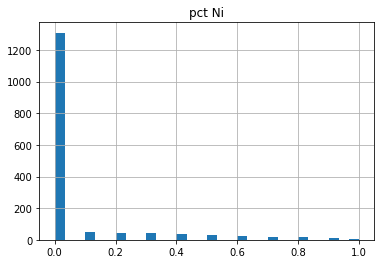

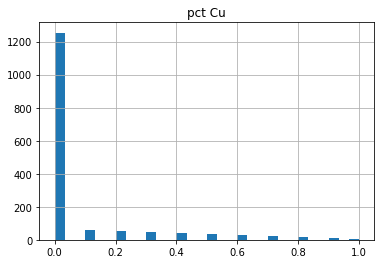

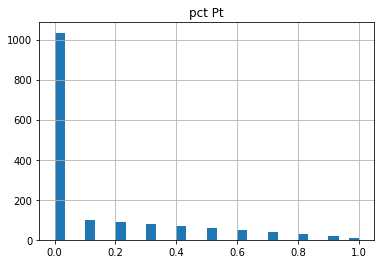

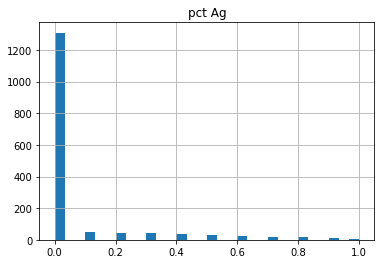

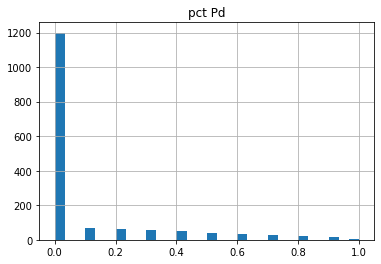

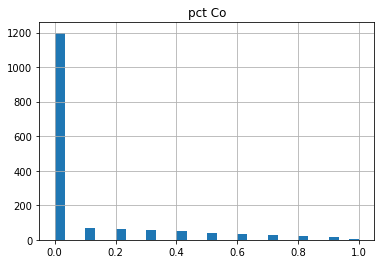

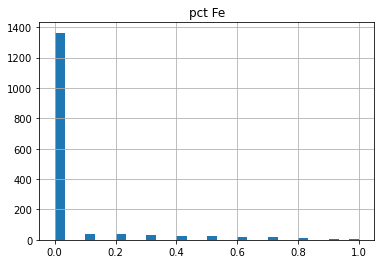

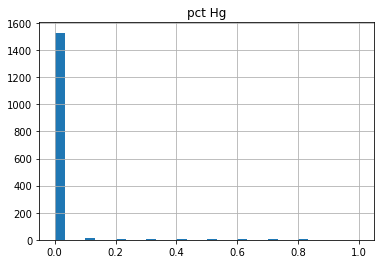

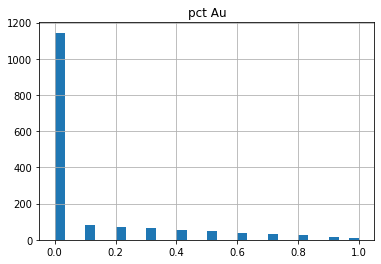

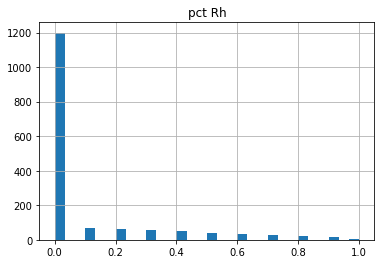

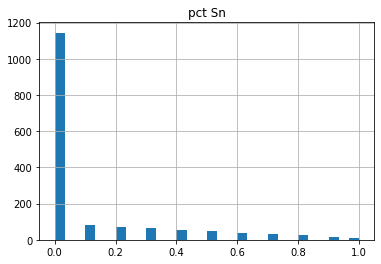

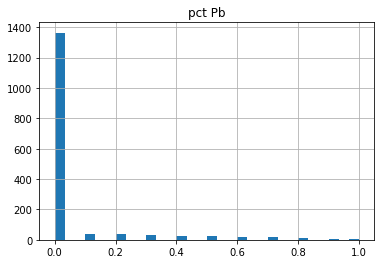

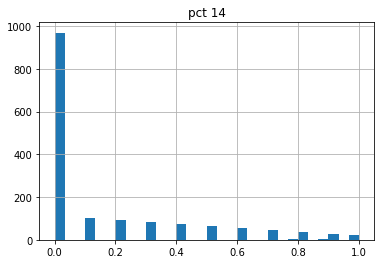

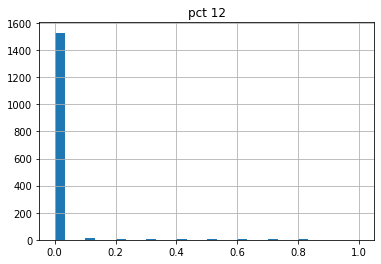

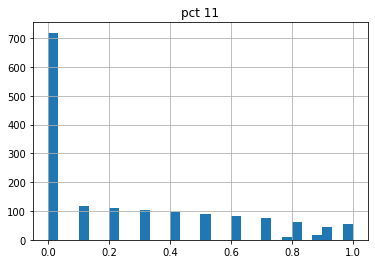

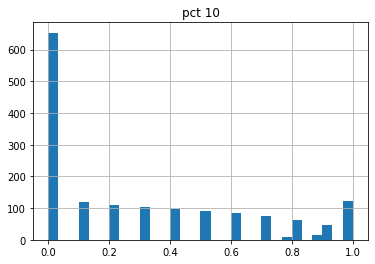

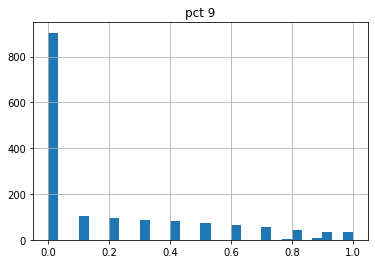

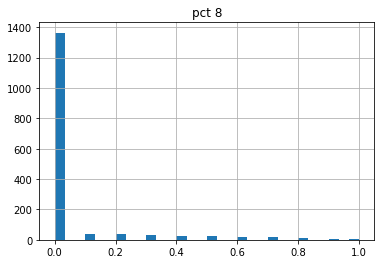

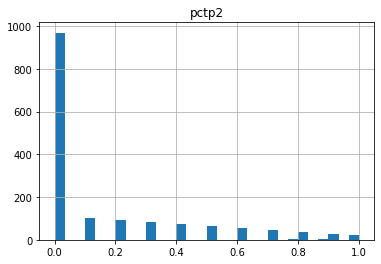

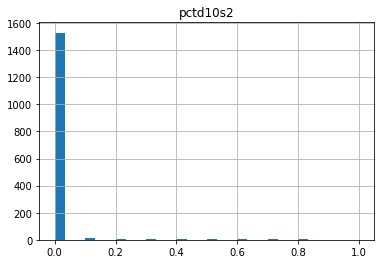

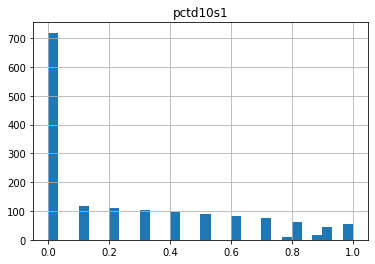

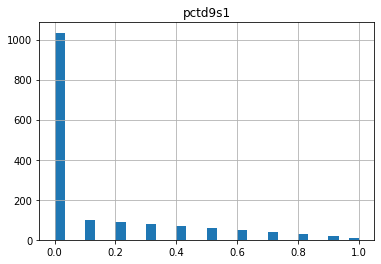

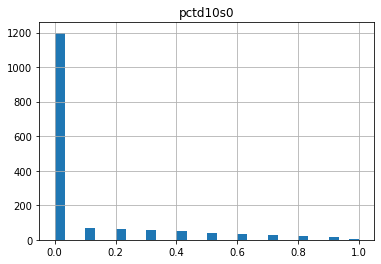

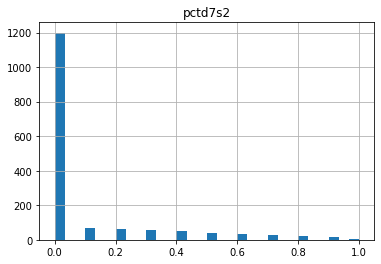

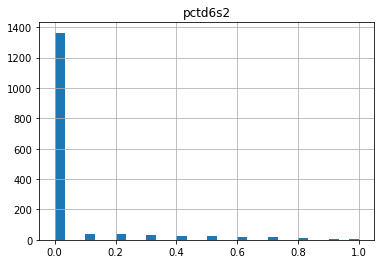

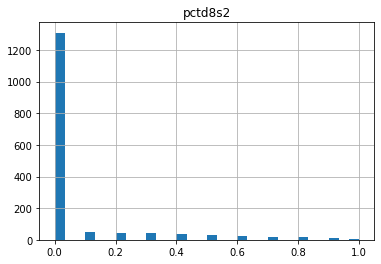

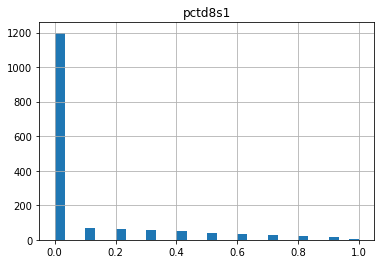

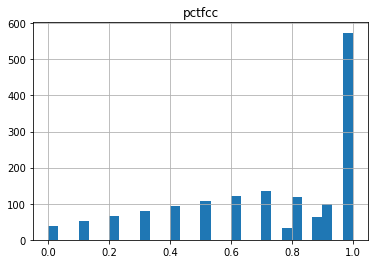

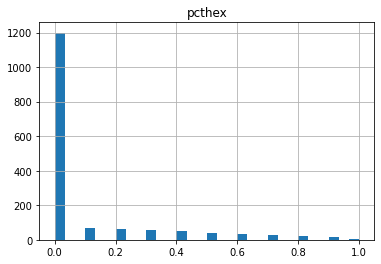

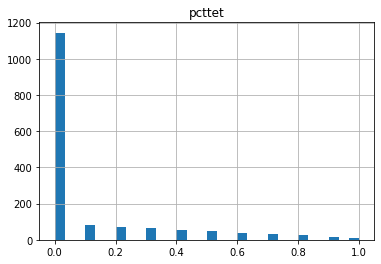

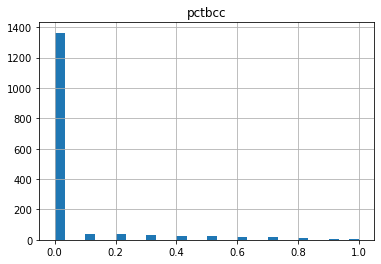

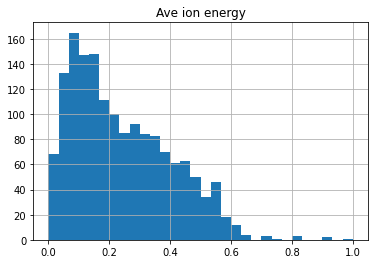

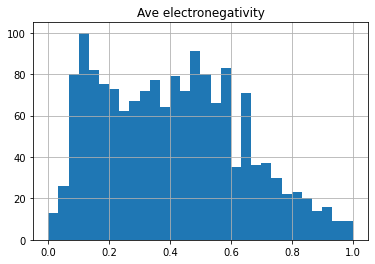

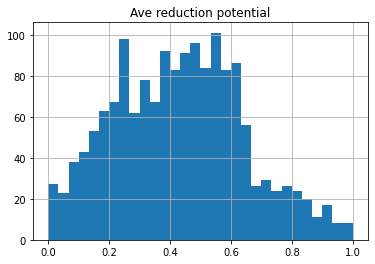

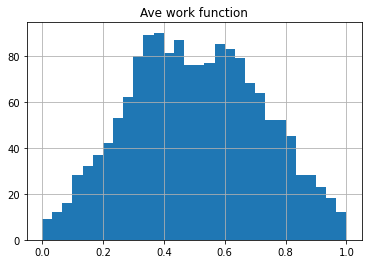

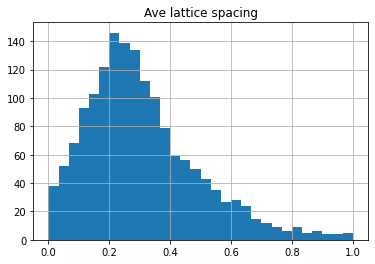

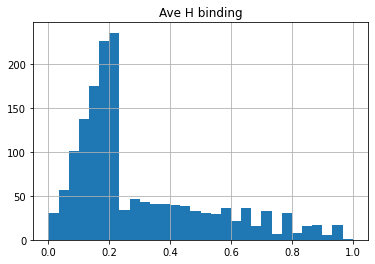

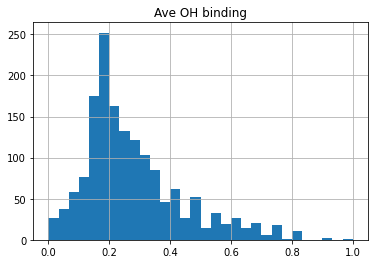

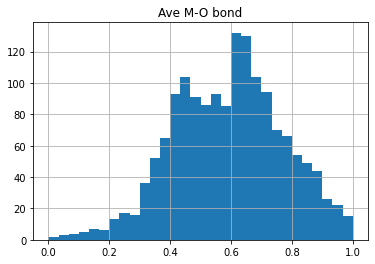

In [ ]:
for c in new_temp.columns:
  new_temp.hist(c,bins=30)
  plt.title(c)
  plt.show()

## Contribution of each element to onset potential

###H$_2$

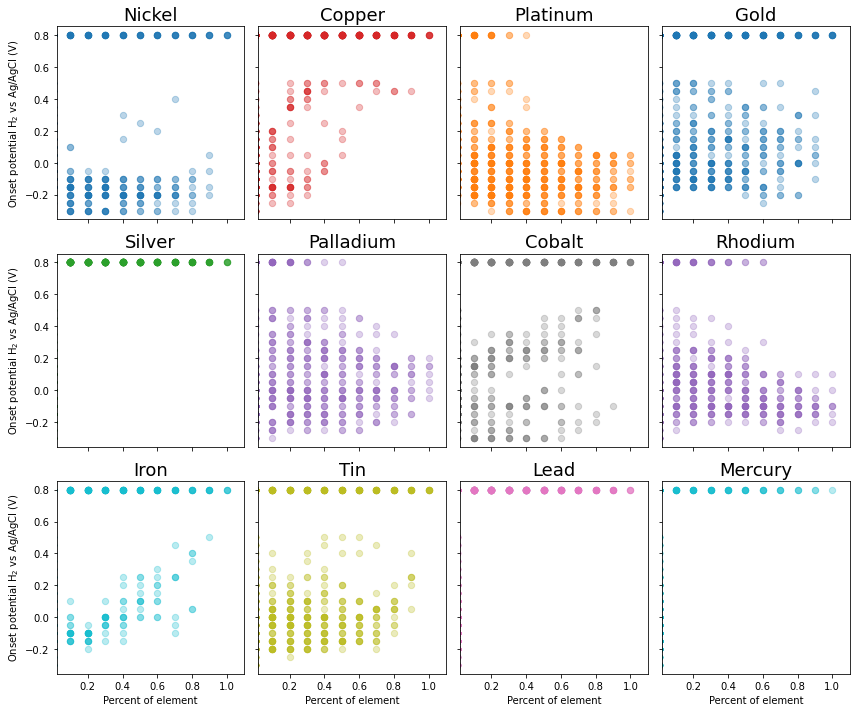

In [ ]:
colors = ["tab:blue","tab:red","tab:orange","tab:green","tab:purple","tab:gray",
          "tab:cyan","tab:olive","tab:pink","tab:blue","tab:gray","tab:green"]
fig, axs = plt.subplots(3,4, sharex=True, sharey=True, figsize=(12,10))
axs[0,0].scatter(df4["pct Ni"],df4["Onset potential H2 Ag/AgCl"],s=40,c=colors[0],alpha=0.3)
axs[0,1].scatter(df4["pct Cu"],df4["Onset potential H2 Ag/AgCl"],s=40,c=colors[1],alpha=0.3)
axs[0,2].scatter(df4["pct Pt"],df4["Onset potential H2 Ag/AgCl"],s=40,c=colors[2],alpha=0.3)
axs[1,0].scatter(df4["pct Ag"],df4["Onset potential H2 Ag/AgCl"],s=40,c=colors[3],alpha=0.3)
axs[1,1].scatter(df4["pct Pd"],df4["Onset potential H2 Ag/AgCl"],s=40,c=colors[4],alpha=0.3)
axs[1,2].scatter(df4["pct Co"],df4["Onset potential H2 Ag/AgCl"],s=40,c=colors[5],alpha=0.3)
axs[2,0].scatter(df4["pct Fe"],df4["Onset potential H2 Ag/AgCl"],s=40,c=colors[6],alpha=0.3)
axs[2,1].scatter(df4["pct Sn"],df4["Onset potential H2 Ag/AgCl"],s=40,c=colors[7],alpha=0.3)
axs[2,2].scatter(df4["pct Pb"],df4["Onset potential H2 Ag/AgCl"],s=40,c=colors[8],alpha=0.3)
axs[0,3].scatter(df4["pct Au"],df4["Onset potential H2 Ag/AgCl"],s=40,c=colors[0],alpha=0.3)
axs[1,3].scatter(df4["pct Rh"],df4["Onset potential H2 Ag/AgCl"],s=40,c=colors[4],alpha=0.3)
axs[2,3].scatter(df4["pct Hg"],df4["Onset potential H2 Ag/AgCl"],s=40,c=colors[6],alpha=0.3)
column_list = ["pct Ni","pct Cu","pct Pt","pct Ag","pct Pd","pct Co","pct Fe","pct Sn","pct Pb","pct Au","pct Rh","pct Hg"]
"""
for i in range(9):
  axs[2,2].scatter(df4.loc[:,column_list[i]],df4["Onset potential H2 Ag/AgCl"],c=colors[i],alpha=0.2)
"""
axs[0,0].set_xlim((0.02,1.1))
axs[0,1].set_xlim((0.02,1.1))
axs[0,2].set_xlim((0.02,1.1))
axs[1,0].set_xlim((0.02,1.1))
axs[1,1].set_xlim((0.02,1.1))
axs[1,2].set_xlim((0.02,1.1))
axs[2,0].set_xlim((0.02,1.1))
axs[2,1].set_xlim((0.02,1.1))
axs[2,2].set_xlim((0.02,1.1))
axs[0,3].set_xlim((0.02,1.1))
axs[1,3].set_xlim((0.02,1.1))
axs[2,3].set_xlim((0.02,1.1))
axs[0,0].set_ylabel("Onset potential H$_2$ vs Ag/AgCl (V)")
axs[1,0].set_ylabel("Onset potential H$_2$ vs Ag/AgCl (V)")
axs[2,0].set_ylabel("Onset potential H$_2$ vs Ag/AgCl (V)")
axs[2,0].set_xlabel("Percent of element")
axs[2,1].set_xlabel("Percent of element")
axs[2,2].set_xlabel("Percent of element")
axs[2,3].set_xlabel("Percent of element")
axs[0,0].set_title("Nickel",fontsize="18")
axs[0,1].set_title("Copper",fontsize="18")
axs[0,2].set_title("Platinum",fontsize="18")
axs[0,3].set_title("Gold",fontsize="18")
axs[1,0].set_title("Silver",fontsize="18")
axs[1,1].set_title("Palladium",fontsize="18")
axs[1,2].set_title("Cobalt",fontsize="18")
axs[1,3].set_title("Rhodium",fontsize="18")
axs[2,0].set_title("Iron",fontsize="18")
axs[2,1].set_title("Tin",fontsize="18")
axs[2,2].set_title("Lead",fontsize="18")
axs[2,3].set_title("Mercury",fontsize="18")
plt.tight_layout()
plt.savefig("Onset potentials vs element percent H2", dpi=300,bbox_inches="tight")
plt.show()

## Contribution of each electron configuration to onset potential

### H2

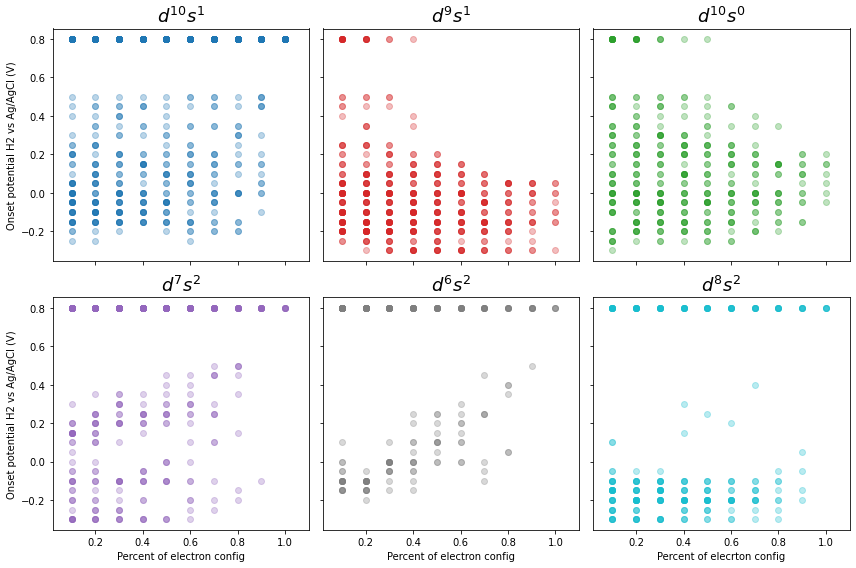

In [ ]:
colors = ["tab:blue","tab:red","tab:orange","tab:green","tab:purple","tab:gray",
          "tab:cyan","tab:olive"]
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12,8))
axs[0,0].scatter(df4["pctd10s1"],df4["Onset potential H2 Ag/AgCl"],c=colors[0],alpha=0.3)
axs[0,1].scatter(df4["pctd9s1"],df4["Onset potential H2 Ag/AgCl"],c=colors[1],alpha=0.3)
axs[0,2].scatter(df4["pctd10s0"],df4["Onset potential H2 Ag/AgCl"],c=colors[3],alpha=0.3)
axs[1,0].scatter(df4["pctd7s2"],df4["Onset potential H2 Ag/AgCl"],c=colors[4],alpha=0.3)
axs[1,1].scatter(df4["pctd6s2"],df4["Onset potential H2 Ag/AgCl"],c=colors[5],alpha=0.3)
axs[1,2].scatter(df4["pctd8s2"],df4["Onset potential H2 Ag/AgCl"],c=colors[6],alpha=0.3)
column_list = ["pctd10s1","pctd9s1","pctd10s0","pctd7s2","pctd6s2","pctd8s2"]
"""
for i in range(6):
  axs[2,2].scatter(df4.loc[:,column_list[i]],df4["Onset potential H2 Ag/AgCl"],c=colors[i],alpha=0.2)
"""
axs[0,0].set_xlim((0.02,1.1))
axs[0,1].set_xlim((0.02,1.1))
axs[0,2].set_xlim((0.02,1.1))
axs[1,0].set_xlim((0.02,1.1))
axs[1,1].set_xlim((0.02,1.1))
axs[1,2].set_xlim((0.02,1.1))
axs[0,0].set_ylabel("Onset potential H2 vs Ag/AgCl (V)")
axs[1,0].set_ylabel("Onset potential H2 vs Ag/AgCl (V)")
axs[1,0].set_xlabel("Percent of electron config")
axs[1,1].set_xlabel("Percent of electron config")
axs[1,2].set_xlabel("Percent of elecrton config")
axs[0,0].set_title("$d^{10}s^1$",fontsize="18")
axs[0,1].set_title("$d^{9}s^1$",fontsize="18")
axs[0,2].set_title("$d^{10}s^0$",fontsize="18")
axs[1,0].set_title("$d^7s^2$",fontsize="18")
axs[1,1].set_title("$d^6s^2$",fontsize="18")
axs[1,2].set_title("$d^8s^2$",fontsize="18")
plt.tight_layout()
plt.savefig("Onset potential H2 vs electronic configuration", dpi=300,bbox_inches="tight")
plt.show()

## Make graph network of Alloys

Ag    6
Co    9
Cu    9
Fe    8
Hg    2
Ni    7
Pb    7
Au    8
Pd    8
Pt    8
Rh    8
Sn    8
Name: connections, dtype: int64


C:\Users\Jeremy\AppData\Local\Temp/ipykernel_340/2053177427.py:68: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  axcb = plt.colorbar(scalmap,norm=matplotlib.colors.Normalize(vmin=0, vmax=9))


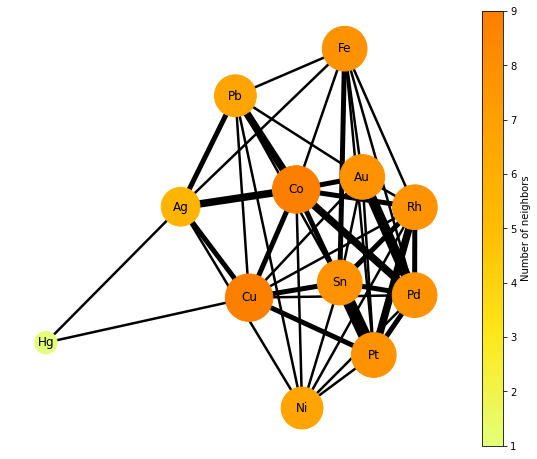

In [ ]:
new_db = db.reset_index()
new_db = new_db.set_index("Atomic #")
A, B, C = [], [], []
for i in range(len(df4)//66):
  A.append(new_db.at[df4['Element A atomic #'].values[i*66],"Element"])
  B.append(new_db.at[df4['Element B atomic #'].values[i*66],"Element"])
  A.append(new_db.at[df4['Element A atomic #'].values[i*66],"Element"])
  B.append(new_db.at[df4['Element C atomic #'].values[i*66],"Element"])
  A.append(new_db.at[df4['Element C atomic #'].values[i*66],"Element"])
  B.append(new_db.at[df4['Element B atomic #'].values[i*66],"Element"])
element_data = pd.DataFrame([A,B]).T
A = np.array(A).T
B = np.array(B).T
stack = np.vstack((A,B)).T
stack2 = []
for i in range(len(stack)):
  stack2.append(''.join(np.sort(stack[i]).tolist()))
ustack2 = np.unique(np.sort(stack2))
edgecount = np.zeros(len(ustack2))
for i in range(len(ustack2)):
  for j in range(len(stack2)):
    flip = stack2[i][2:4]
    flip = flip + stack2[i][0:2]
    if ((ustack2[i] == stack2[j]) or (ustack2[i] == flip )):
      edgecount[i] += 1
element_data.columns = ['Element A','Element B']
AA, BB, CC = [], [], []
for i in range(len(element_data)):
  AA.append(element_data.iloc[i,0])
  BB.append(element_data.iloc[i,1])
all_elements = np.sort(np.unique(np.array(AA + BB)))
all_elements = pd.DataFrame([all_elements,np.arange(0,len(all_elements))]).T
all_elements.columns = ['Elements','index']
all_elements = all_elements.set_index('Elements')
pairs = np.zeros((len(ustack2),2))
for i in range(len(ustack2)):
  pairs[i,0]= all_elements.at[ustack2[i][0:2],"index"]
  pairs[i,1]= all_elements.at[ustack2[i][2:4],"index"]
pairs = list(map(tuple,pairs))
G = nx.Graph()
for i in range(len(ustack2)):
  G.add_edge(ustack2[i][0:2] , ustack2[i][2:4], weight=edgecount[i])
fig ,ax = plt.subplots(figsize=(10,8))
norm = matplotlib.colors.Normalize(vmin=1, vmax=9)
leaderboard = {}
for x in G.nodes:
  leaderboard[x] = len(G[x])
s = pd.Series(leaderboard, name='connections')
print(s)
graph_connections = s.to_frame()
#T = nx.draw_kamada_kawai(G, node_size=(250*graph_connections.values),width=(2.5*edgecount),
#            with_labels=True,cmap=plt.cm.Wistia,node_color=graph_connections.values)
T = nx.draw_spring(G, node_size=(250*graph_connections.values),width=(2.5*edgecount),
            with_labels=True,cmap=plt.cm.Wistia,node_color=graph_connections.values)
#T = nx.draw_circular(G, node_size=(250*graph_connections.values),width=(2.5*edgecount),
#            with_labels=True,cmap=plt.cm.Wistia,node_color=graph_connections.values)
scalmap = plt.cm.ScalarMappable(cmap=plt.cm.Wistia)
scalmap.set_clim(1,9)
axcb = plt.colorbar(scalmap,norm=matplotlib.colors.Normalize(vmin=0, vmax=9))
axcb.set_label('Number of neighbors')
#plt.show()
plt.savefig("graph network of elements in data", dpi=300,bbox_inches="tight")
#display(graph_connections.values)


## Test train split

In [ ]:
X = df4.drop(["Sample ID","Onset potential H2 Ag/AgCl","Element A atomic #","Element B atomic #",
              "Element C atomic #","Periodic group of A","Periodic group of B","Periodic group of C",
              "Electron configuration of A","Electron configuration of B","Electron configuration of C",
              "Electronegativity of A","Electronegativity of B","Electronegativity of C",
              "Reduction potential of A","Reduction potential of B","Reduction potential of C",
              "Ionization energy of A","Ionization energy of B","Ionization energy of C",
              "Crystal structure A","Crystal structure B","Crystal structure C",'Ais78', 'Ais46', 'Ais27',
              'Ais26', 'Ais25', 'Ais77', 'Ais28', 'Ais29', 'Ais47', 'Ais79', 'Ais45', 'Ais24','Ais50',
              'Ais82','Ais80', 'Bis78', 'Bis46','Bis27', 'Bis26', 'Bis25', 'Bis77', 'Bis28', 'Bis29',
              'Bis47', 'Bis79', 'Bis45', 'Bis24','Bis50','Bis82','Bis80','Cis78','Cis46', 'Cis27', 'Cis26',
              'Cis25', 'Cis77', 'Cis28', 'Cis29', 'Cis47', 'Cis79', 'Cis45', 'Cis24','Cis50','Cis82',
              'Cis80','Aisd9s1', 'Aisd10s0', 'Aisd7s2', 'Aisd6s2', 'Aisd8s2', 'Aisd10s1', 'Aisd8s1',
              'Aisd5s1','Aisp2','Aisd10s2','Bisd9s1', 'Bisd10s0', 'Bisd7s2', 'Bisd6s2', 'Bisd8s2',
              'Bisd10s1', 'Bisd8s1', 'Bisd5s1','Bisp2','Bisd10s2','Cisd9s1', 'Cisd10s0', 'Cisd7s2',
              'Cisd6s2', 'Cisd8s2', 'Cisd10s1', 'Cisd8s1', 'Cisd5s1','Cisp2','Cisd10s2','Aisfcc','Aishex',
              'Aisbcc', 'Aiscub','Aistet', 'Bisfcc', 'Bishex','Bisbcc', 'Biscub','Bistet','Cisfcc', 'Cishex', 'Cisbcc',
              'Ciscub','Cistet','Percent A', 'Percent B', 'Percent C', 'Work function A','Work function B',
              'Work function C', 'Lattice spacing A','Lattice spacing B', 'Lattice spacing C',
              'H binding A','H binding B','H binding C','Ais11','Ais10','Ais9','Ais8','Ais7','Ais6',
              'Ais12', 'Ais14','Bis11','Bis10','Bis9','Bis8','Bis7','Bis6','Bis12','Bis14','Cis11','Cis10',
              'Cis9','Cis8','Cis7','Cis6','Cis12','Cis14','M-O bond strength A','M-O bond strength B',
              'M-O bond strength C','OH binding A','OH binding B','OH binding C'],axis=1)
#print(X.columns)
y = np.array(df4['Onset potential H2 Ag/AgCl']).T
poly = PolynomialFeatures(2,interaction_only=True)
X_train, X_test, y_train, y_test = train_test_split(poly.fit_transform(X), y.ravel(),test_size=0.15,
                                                    random_state=0)
'''
# The test-train split is to use SnPtRh as test data
X_train = poly.fit_transform(pd.concat([X.iloc[:1320,:],X.iloc[1386:,:]]))
X_test = poly.fit_transform(X.iloc[1320:1386,:])
y_train = np.concatenate((y.ravel()[:1320],y.ravel()[1386:]))
y_test = y.ravel()[1320:1386]
'''
features = ['constant']
for i in X.columns:
  features.append(i)
for i in range(len(X.columns)):
  for t in range(len(X.columns[i:])):
    if X.columns[i] != X.columns[i:][t]:
      features.append(X.columns[i] + ' * ' + X.columns[i:][t])
      #features_names.append(i + ' * ' + t)
#display(features)
"""
for i in X.columns:
  for t in X.columns:
    for g in X.columns:
      if i != t and i != g and t != g:
        features.append(i + ' * ' + t + ' * ' + g)
"""
Xy_train = pd.DataFrame(data=X_train)
Xy_train["y_train"] = y_train
Xy_test = pd.DataFrame(data=X_test)
Xy_test["y_test"] = y_test

## Visualization

### def data viz plot

In [ ]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
elements1 = ["NiPtPd","CoNiPt","SnAuPd","RhCoAu","AgCuHg","AgCoCu"]
elements2 = ["CuSnRh","AuCuPd","AgCoFe","AgNiPb","FeRhPd","FePtSn"]
elements3 = ["AgCoPb","AuFePb","CuPbSn","AuCuPt","NiPtRh","CoPdRh"]
elements4 = ["AuCoPd","SnPtNi","SnPtRh","AuPtRh","SnPtAu","SnPdPt"]

def visualize_groups_quart(y, y_pred, y_test, groups, X, train_in, test_in):
    # Visualize dataset groups
    fig = plt.figure(figsize=(18, 4))
    ax = fig.subplots()
    for i in range(len(elements1)):
      ax.annotate(elements1[i],(20+i*66,-0.2),fontsize=14,backgroundcolor="white")
    ax.scatter(
        range(len(groups)),
        [0] * len(groups),
        c=groups,
        marker="_",
        lw=30,
        s=1,
        cmap=cm.Set1,
    )
    B = ax.scatter(
        range(len(y)),
        [3] * len(y),
        c=y,
        marker="_",
        lw=30,
        s=1,
        cmap=cmap_data,
    )
    train_ind = train_in[train_in<=quarter]
    ax.scatter(
        train_in,
        [4] * len(train_in),
        c=np.zeros(len(train_in)),
        marker="_",
        lw=30,
        s=1,
        cmap=cmap_data,
        )
    test_ind = test_in[test_in<=quarter]
    ax.scatter(
        test_in,
        [4] * len(test_in),
        c=np.ones(len(test_in))*100,
        marker="_",
        lw=30,
        s=1,
        cmap=cmap_cv,
        )
    #y_pred = regr(X)
    error = y[test_in]-y_pred[test_in]
    A = ax.scatter(
        test_in,
        [1] * len(test_in),
        c=error,
        marker="_",
        lw=30,
        s=1,
        cmap=cm.nipy_spectral,
        vmax=0.65,
        vmin=-0.35
        )
    axins1 = inset_axes(ax,
                   width="1%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='right',
                   bbox_to_anchor=(0.11, 0.,1,1),
                   bbox_transform=ax.transAxes,
                   borderpad=2,
                   )
    axins2 = inset_axes(ax,
                   width="1%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='right',
                   bbox_to_anchor=(0.05, 0., 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=2,
                   )
    cbar = plt.colorbar(A,pad=0.0,cax=axins1)
    cbar.set_label('Error (V)',labelpad=3, rotation=270)
    cbar2 = plt.colorbar(B,pad=0.0,cax=axins2)
    cbar2.set_label('Onset voltage vs AgCl (V)',labelpad=3,rotation=270)
    ax.scatter(
        test_in,
        [2] * len(test_in),
        c=y_pred[test_in],
        marker="_",
        lw=30,
        s=1,
        cmap=cmap_data,
        )
    ax.set(
        ylim=[-0.5, 4.5],
        yticks=[0, 1, 2.0, 3, 4],
        xlim=[-4,quarter+3],
        yticklabels=["Individual\narrays", "Prediction error","Predicted\nonset potential",
                     "True onset\npotential" ,"Test\nTrain split"],
        xlabel="Sample index",
    )
    ax.tick_params(labelsize=13)
    ax.set_xlabel("Sample index",fontsize=13)
    plt.savefig("data_vis.png",dpi=350)


def visualize_groups_half(y, y_pred, y_test, groups, X, train_in, test_in):
    # Visualize dataset groups
    fig = plt.figure(figsize=(18, 4))
    ax = fig.subplots()
    for i in range(len(elements2)):
      ax.annotate(elements2[i],(quarter+21+i*66,-0.2),fontsize=14,backgroundcolor="white")
    ax.scatter(
        range(quarter+1, len(groups)+quarter+1),
        [0] * len(groups),
        c=groups,
        marker="_",
        lw=30,
        s=1,
        cmap=cm.Set1,
    )
    B = ax.scatter(
        range(quarter+1, len(y)+quarter+1),
        [3] * len(y),
        c=y,
        marker="_",
        lw=30,
        s=1,
        cmap=cmap_data,
    )
    train_ind = train_in[(train_in>quarter)&(train_in<=half)]
    ax.scatter(
        train_in,
        [4] * len(train_in),
        c=np.zeros(len(train_in)),
        marker="_",
        lw=30,
        s=1,
        cmap=cmap_data,
        )
    test_ind = test_in[(test_in>quarter)&(test_in<=half)]
    ax.scatter(
        test_in,
        [4] * len(test_in),
        c=np.ones(len(test_in))*100,
        marker="_",
        lw=30,
        s=1,
        cmap=cmap_cv,
        )
    #y_pred = regr(X)
    error = y[test_in-quarter-1]-y_pred[test_in-quarter-1]
    A = ax.scatter(
        test_in,
        [1] * len(test_in),
        c=error,
        marker="_",
        lw=30,
        s=1,
        cmap=cm.nipy_spectral,
        vmax=0.65,
        vmin=-0.35
        )
    axins1 = inset_axes(ax,
                   width="1%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='right',
                   bbox_to_anchor=(0.11, 0.,1,1),
                   bbox_transform=ax.transAxes,
                   borderpad=2,
                   )
    axins2 = inset_axes(ax,
                   width="1%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='right',
                   bbox_to_anchor=(0.05, 0., 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=2,
                   )
    cbar = plt.colorbar(A,pad=0.0,cax=axins1)
    cbar.set_label('Error (V)',labelpad=3, rotation=270)
    cbar2 = plt.colorbar(B,pad=0.0,cax=axins2)
    cbar2.set_label('Onset voltage vs AgCl (V)',labelpad=3,rotation=270)
    ax.scatter(
        test_in,
        [2] * len(test_in),
        c=y_pred[test_in-quarter-1],
        marker="_",
        lw=30,
        s=1,
        cmap=cmap_data,
        )
    ax.set(
        ylim=[-0.5, 4.5],
        yticks=[0, 1, 2.0, 3, 4],
        xlim=[quarter-4,half+4],
        yticklabels=["Individual\narrays", "Prediction error","Predicted\nonset potential",
                     "True onset\npotential" ,"Test\nTrain split",],
        xlabel="Sample index",
    )
    ax.tick_params(labelsize=13)
    ax.set_xlabel("Sample index",fontsize=13)
    plt.savefig("data_vis2.png",dpi=350)


def visualize_groups_three_qs(y, y_pred, y_test, groups, X, train_in, test_in):
    # Visualize dataset groups
    fig = plt.figure(figsize=(18, 4))
    ax = fig.subplots()
    for i in range(len(elements3)):
      ax.annotate(elements3[i],(half+21+i*66,-0.2),fontsize=14,backgroundcolor="white")
    ax.scatter(
        range(half+1, len(groups)+half+1),
        [0] * len(groups),
        c=groups,
        marker="_",
        lw=30,
        s=1,
        cmap=cm.Set1,
    )
    B = ax.scatter(
        range(half+1, len(y)+half+1),
        [3] * len(y),
        c=y,
        marker="_",
        lw=30,
        s=1,
        cmap=cmap_data,
    )
    train_ind = train_in[(train_in>half)&(train_in<=three_qs)]
    ax.scatter(
        train_in,
        [4] * len(train_in),
        c=np.zeros(len(train_in)),
        marker="_",
        lw=30,
        s=1,
        cmap=cmap_data,
        )
    test_ind = test_in[(test_in>half)&(test_in<=three_qs)]
    ax.scatter(
        test_in,
        [4] * len(test_in),
        c=np.ones(len(test_in))*100,
        marker="_",
        lw=30,
        s=1,
        cmap=cmap_cv,
        )
    #y_pred = regr(X)
    error = y[test_in-half-1]-y_pred[test_in-half-1]
    A = ax.scatter(
        test_in,
        [1] * len(test_in),
        c=error,
        marker="_",
        lw=30,
        s=1,
        cmap=cm.nipy_spectral,
        vmax=0.65,
        vmin=-0.35
        )
    axins1 = inset_axes(ax,
                   width="1%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='right',
                   bbox_to_anchor=(0.11, 0.,1,1),
                   bbox_transform=ax.transAxes,
                   borderpad=2,
                   )
    axins2 = inset_axes(ax,
                   width="1%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='right',
                   bbox_to_anchor=(0.05, 0., 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=2,
                   )
    cbar = plt.colorbar(A,pad=0.0,cax=axins1)
    cbar.set_label('Error (V)',labelpad=3, rotation=270)
    cbar2 = plt.colorbar(B,pad=0.0,cax=axins2)
    cbar2.set_label('Onset voltage vs AgCl (V)',labelpad=3,rotation=270)
    ax.scatter(
        test_in,
        [2] * len(test_in),
        c=y_pred[test_in-half-1],
        marker="_",
        lw=30,
        s=1,
        cmap=cmap_data,
        )
    ax.set(
        ylim=[-0.5, 4.5],
        yticks=[0, 1, 2.0, 3, 4],
        xlim=[half-4,three_qs+4],
        yticklabels=["Individual\narrays", "Prediction error","Predicted\nonset potential",
                     "True onset\npotential" ,"Test\nTrain split",],
        xlabel="Sample index",
    )
    ax.tick_params(labelsize=13)
    ax.set_xlabel("Sample index",fontsize=13)
    plt.savefig("data_vis3.png",dpi=350)


def visualize_groups_full(y, y_pred, y_test, groups, X, train_in, test_in):
    # Visualize dataset groups
    fig = plt.figure(figsize=(18, 4))
    ax = fig.subplots()
    for i in range(len(elements4)):
      ax.annotate(elements4[i],(three_qs+21+i*66,-0.2),fontsize=14,backgroundcolor="white")
    ax.scatter(
        range(three_qs, len(groups)+three_qs),
        [0] * len(groups),
        c=groups,
        marker="_",
        lw=30,
        s=1,
        cmap=cm.Set1,
    )
    B = ax.scatter(
        range(three_qs+1, len(y)+three_qs+1),
        [3] * len(y),
        c=y,
        marker="_",
        lw=30,
        s=1,
        cmap=cmap_data,
    )
    train_ind = train_in[train_in>=three_qs]
    ax.scatter(
        train_in,
        [4] * len(train_in),
        c=np.zeros(len(train_in)),
        marker="_",
        lw=30,
        s=1,
        cmap=cmap_data,
        )
    test_ind = test_in[test_in>=three_qs]
    ax.scatter(
        test_in,
        [4] * len(test_in),
        c=np.ones(len(test_in))*100,
        marker="_",
        lw=30,
        s=1,
        cmap=cmap_cv,
        )
    #y_pred = regr(X)
    error = y[test_in-three_qs-1]-y_pred[test_in-three_qs-1]
    A = ax.scatter(
        test_in,
        [1] * len(test_in),
        c=error,
        marker="_",
        lw=30,
        s=1,
        cmap=cm.nipy_spectral,
        vmax=0.65,
        vmin=-0.35
        )
    axins1 = inset_axes(ax,
                   width="1%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='right',
                   bbox_to_anchor=(0.11, 0.,1,1),
                   bbox_transform=ax.transAxes,
                   borderpad=2,
                   )
    axins2 = inset_axes(ax,
                   width="1%",  # width = 5% of parent_bbox width
                   height="90%",  # height : 50%
                   loc='right',
                   bbox_to_anchor=(0.05, 0., 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=2,
                   )
    cbar = plt.colorbar(A,pad=0.0,cax=axins1)
    cbar.set_label('Error (V)',labelpad=3, rotation=270)
    cbar2 = plt.colorbar(B,pad=0.0,cax=axins2)
    cbar2.set_label('Onset voltage vs AgCl (V)',labelpad=3,rotation=270)
    ax.scatter(
        test_in,
        [2] * len(test_in),
        c=y_pred[test_in-three_qs-1],
        marker="_",
        lw=30,
        s=1,
        cmap=cmap_data,
        )
    ax.set(
        ylim=[-0.5, 4.5],
        yticks=[0, 1, 2.0, 3, 4],
        xlim=[three_qs-4,n_points+4],
        yticklabels=["Individual\narrays", "Prediction error","Predicted\nonset potential",
                     "True onset\npotential" ,"Test\nTrain split",],
        xlabel="Sample index",
    )
    ax.tick_params(labelsize=13)
    ax.set_xlabel("Sample index",fontsize=13)
    plt.savefig("data_vis4.png",dpi=350)



### Plot test train split

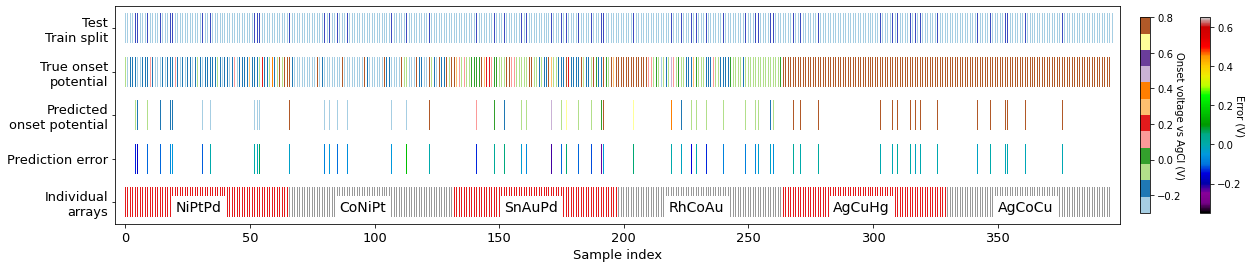

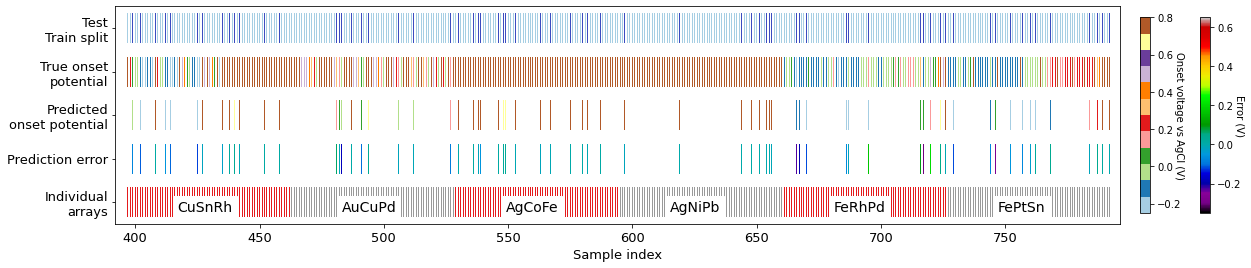

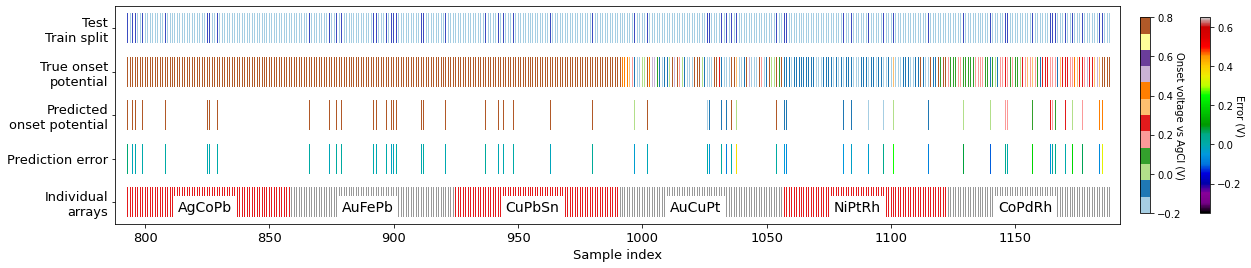

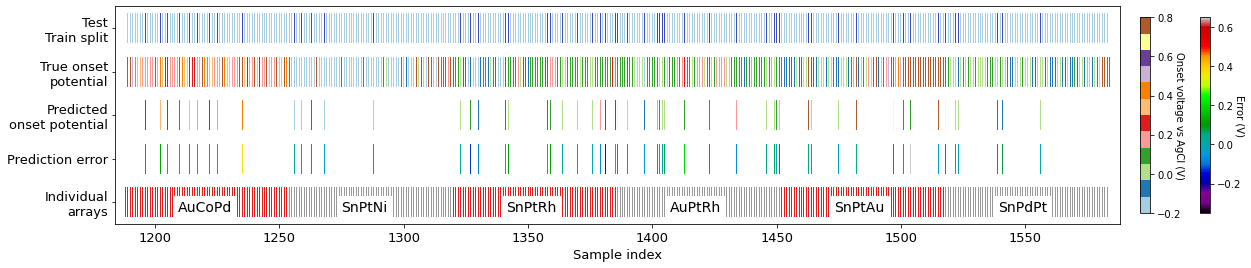

In [ ]:
X = df4.drop(["Sample ID","Onset potential H2 Ag/AgCl","Element A atomic #","Element B atomic #",
              "Element C atomic #","Periodic group of A","Periodic group of B","Periodic group of C",
              "Electron configuration of A","Electron configuration of B","Electron configuration of C",
              "Electronegativity of A","Electronegativity of B","Electronegativity of C",
              "Reduction potential of A","Reduction potential of B","Reduction potential of C",
              "Ionization energy of A","Ionization energy of B","Ionization energy of C",
              "Crystal structure A","Crystal structure B","Crystal structure C",'Ais78', 'Ais46', 'Ais27',
              'Ais26', 'Ais25', 'Ais77', 'Ais28', 'Ais29', 'Ais47', 'Ais79', 'Ais45', 'Ais24','Ais50',
              'Ais82','Ais80', 'Bis78', 'Bis46','Bis27', 'Bis26', 'Bis25', 'Bis77', 'Bis28', 'Bis29',
              'Bis47', 'Bis79', 'Bis45', 'Bis24','Bis50','Bis82','Bis80','Cis78','Cis46', 'Cis27', 'Cis26',
              'Cis25', 'Cis77', 'Cis28', 'Cis29', 'Cis47', 'Cis79', 'Cis45', 'Cis24','Cis50','Cis82',
              'Cis80','Aisd9s1', 'Aisd10s0', 'Aisd7s2', 'Aisd6s2', 'Aisd8s2', 'Aisd10s1', 'Aisd8s1',
              'Aisd5s1','Aisp2','Aisd10s2','Bisd9s1', 'Bisd10s0', 'Bisd7s2', 'Bisd6s2', 'Bisd8s2',
              'Bisd10s1', 'Bisd8s1', 'Bisd5s1','Bisp2','Bisd10s2','Cisd9s1', 'Cisd10s0', 'Cisd7s2',
              'Cisd6s2', 'Cisd8s2', 'Cisd10s1', 'Cisd8s1', 'Cisd5s1','Cisp2','Cisd10s2','Aisfcc','Aishex',
              'Aisbcc', 'Aiscub','Aistet', 'Bisfcc', 'Bishex','Bisbcc', 'Biscub','Bistet','Cisfcc', 'Cishex', 'Cisbcc',
              'Ciscub','Cistet','Percent A', 'Percent B', 'Percent C', 'Work function A','Work function B',
              'Work function C', 'Lattice spacing A','Lattice spacing B', 'Lattice spacing C',
              'H binding A','H binding B','H binding C','Ais11','Ais10','Ais9','Ais8','Ais7','Ais6',
              'Ais12', 'Ais14','Bis11','Bis10','Bis9','Bis8','Bis7','Bis6','Bis12','Bis14','Cis11','Cis10',
              'Cis9','Cis8','Cis7','Cis6','Cis12','Cis14','M-O bond strength A','M-O bond strength B',
              'M-O bond strength C','OH binding A','OH binding B','OH binding C'],axis=1)
y = np.array(df4['Onset potential H2 Ag/AgCl']).T
n_points = len(X)
half = n_points//2
quarter = half//2
three_qs = half+quarter
groups = []
for i in range(24):
  for ii in range(66):
    if i % 2 == 0:
      groups.append(0)
    else:
      groups.append(1)

poly = PolynomialFeatures(2,interaction_only=True)
torch.manual_seed(1)    # reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(),test_size=0.15,
                                                   random_state=0,shuffle=True)
test_ind = X_test.index.to_numpy()
train_ind = X_train.index.to_numpy()
X_testP = poly.fit_transform(X_test)
X_trainP = poly.fit_transform(X_train)
PX = poly.fit_transform(X)
PXt = torch.from_numpy(PX)
prediction_all = net(PXt.to(cuda))
prediction_all = prediction_all.cpu()
prediction_all_T = prediction_all.data.numpy().T[0]
rs = ShuffleSplit(n_splits=1)
for train_in, test_in in rs.split(X):
  visualize_groups_quart(y[:quarter], prediction_all_T[:quarter], y_test[:quarter], groups[:quarter],
                       PX[:quarter], train_ind[train_ind<=quarter], test_ind[test_ind<=quarter])
  visualize_groups_half(y[quarter:half], prediction_all_T[quarter:half], y_test[quarter:half], groups[quarter:half],
                      PX[quarter:half],train_ind[(train_ind>quarter)&(train_ind<=half)], test_ind[(test_ind>quarter)&(test_ind<=half)])
  visualize_groups_three_qs(y[half:three_qs], prediction_all_T[half:three_qs], y_test[half:three_qs], groups[half:three_qs],
                          PX[half:three_qs],train_ind[(train_ind>half)&(train_ind<=three_qs)], test_ind[(test_ind>half)&(test_ind<=three_qs)])
  visualize_groups_full(y[three_qs:], prediction_all_T[three_qs:], y_test[three_qs:], groups[three_qs:],
                      PX[three_qs:],train_ind[train_ind>three_qs], test_ind[test_ind>three_qs])

In [ ]:
print(len(X_test),len(test_ind))
Error = y_test-prediction_all_T[test_ind]

print(np.max(Error),np.min(Error))

238 238
0.6631220906972886 -0.5304759979248047


## Clustering with UMAP

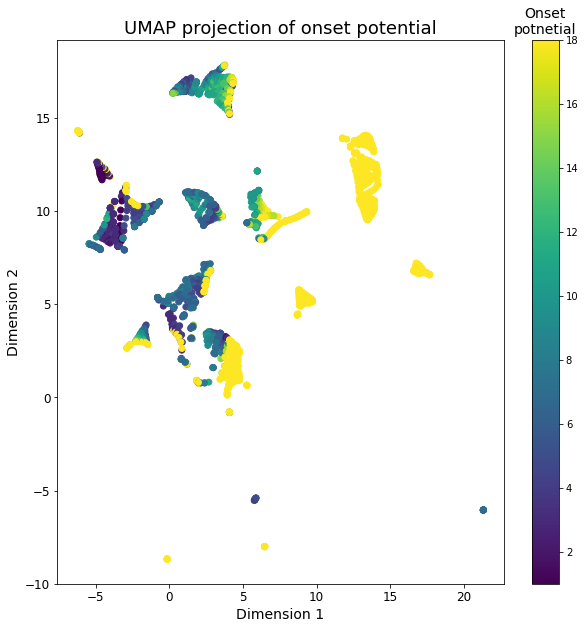

In [ ]:
L = df4['Onset potential H2 Ag/AgCl'].rank(method="dense").astype(int)
X_map = UMAP(random_state=2,n_neighbors=8,min_dist=0.011).fit_transform(poly.fit_transform(X))
data=np.append(X_map,L.to_numpy().reshape(-1,1),1)
"""
fig = px.scatter(x=data[:,0], y=data[:,1],color=L.to_list(),width=900, height=900,
                 hover_name=df4["Sample ID"])
fig.show(renderer="colab")
"""
plt.figure(figsize=(10,10))
plt.scatter(data[:,0],data[:,1],c=L.to_list())
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Dimension 1", fontsize=14)
plt.ylabel("Dimension 2",fontsize=14)
plt.title("UMAP projection of onset potential",fontsize=18)
cb = plt.colorbar()
cb.ax.set_title("Onset\npotnetial",fontsize=14)
plt.savefig("UMAP H2 onset.png",dpi=300)
UMAP_data = pd.DataFrame([df4['Sample ID'],L,data[:,0],data[:,1]]).transpose()
UMAP_data.to_csv("UMAP.csv")

## Define scatter plot

In [ ]:
# Function to create parity plots for comparing models 
def scatter_hist(x1, y1, x2, y2, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    train_color = 'tab:orange'
    #train_color = 'xkcd:tomato red'
    #train_color = 'xkcd:red wine'
    test_color = 'tab:blue'
    # the scatter plot:
    ax.scatter(x1, y1,alpha=0.2,s=100,color=test_color,label='Test data',marker="^")
    ax.scatter(x2, y2,alpha=0.2,s=100,color=train_color,label='Training data')
    ax.plot([-1,2],[-1,2],linewidth=1,linestyle='dashed',color="black")
    ax.set_xlabel("Predicted value", fontsize=14)
    ax.set_ylabel("True value", fontsize=14)
    label = [mpatches.Circle((0,0),radius=1,color=test_color),mpatches.Circle((0,0),radius=1,color=train_color)]
    ax.legend(loc='upper left',bbox_to_anchor=(0.05, 0.8),handles=label,labels=['test data','training data'],
              framealpha=0.6)
    # now determine nice limits by hand:
    binwidth = 0.05
    xymax = max(np.max(np.abs(x1)), np.max(np.abs(y1)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-0.4, 0.9, binwidth)
    ax_histx.hist(x1, bins=bins,alpha=1,color=test_color)
    ax_histy.hist(y1, bins=bins,alpha=1, orientation='horizontal',color=test_color)
    ax_histx.hist(x2, bins=bins,alpha=0.45,color=train_color)
    ax_histy.hist(y2, bins=bins,alpha=0.45, orientation='horizontal',color=train_color)
    ax_histy.set_xlim((0,30))
    ax_histx.set_ylim((0,30))
    ax_histx.set_yticks([0, 100,200,300])
    ax_histy.set_xticks([0, 100,200,300])
    ax.set_xlim((-0.4,0.9))
    ax.set_ylim((-0.4,0.9))
    #ax_histx.set_yticks([0,10,20,30])
    #ax_histy.set_xticks([0,10,20,30])

# definitions for the axes
left, width = 0.1, 0.6
bottom, height = 0.1, 0.6
spacing = 0.02
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

## Gradient boosted trees

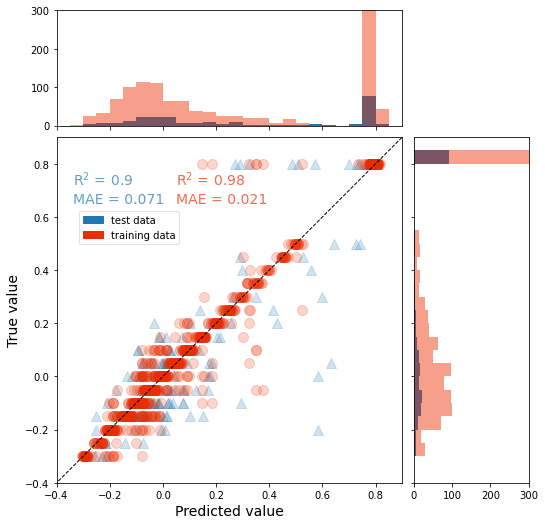

In [ ]:
#regr = DecisionTreeRegressor(random_state=0,criterion="friedman_mse")
regr_GB = GradientBoostingRegressor(random_state=0,n_estimators=1000,min_impurity_decrease=0.000001,
                             criterion="squared_error",min_samples_leaf=4,max_depth=12)
#cv = ShuffleSplit(n_splits=7, test_size=0.1, random_state=1)
#scores = cross_validate(regr, X, y.ravel(),cv=cv,return_train_score=True)
#print(scores)
regr_GB.fit(Xy_train.iloc[:,:-1],Xy_train.iloc[:,-1])
y_predict_test_GB = regr_GB.predict(Xy_test.iloc[:,:-1])
y_predict_train_GB = regr_GB.predict(Xy_train.iloc[:,:-1])
test_score = regr_GB.score(Xy_test.iloc[:,:-1], Xy_test.iloc[:,-1])
train_score = regr_GB.score(Xy_train.iloc[:,:-1], Xy_train.iloc[:,-1])

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
scatter_hist(y_predict_test_GB, y_test, y_predict_train_GB, y_train, ax, ax_histx, ax_histy)
ax.set_xlabel("Predicted value", fontsize=14)
ax.set_ylabel("True value", fontsize=14)
ax.annotate('MAE = {:.2}'.format(mean_absolute_error(y_test,y_predict_test_GB)),
            (-0.34,0.65),fontsize=14,color='tab:blue',alpha=0.7)
ax.annotate('R$^2$ = {:.2}'.format(test_score),
            (-0.34,0.72),fontsize=14,color='tab:blue',alpha=0.7)
ax.annotate('MAE = {:.2}'.format(mean_absolute_error(y_train,y_predict_train_GB)),
            (0.05,0.65),fontsize=14,color='xkcd:tomato red',alpha=0.7)
ax.annotate('R$^2$ = {:.2}'.format(train_score),
            (0.05,0.72),fontsize=14,color='xkcd:tomato red',alpha=0.7)
#print('R$^2$ = {:.2}'.format(score))
#print('RMSE = {:.3}'.format(mean_squared_error(y_test,y_predict,squared=False)))
plt.savefig("Random Forest/Results from tree model with H2", dpi=300, 
            bbox_inches="tight")

C:\Users\Jeremy\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Jeremy\AppData\Local\Temp/ipykernel_14156/1502475673.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(sorted_features)


22 22


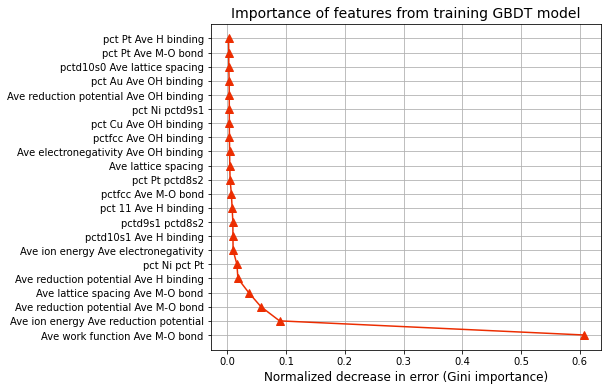

In [ ]:
zipped = zip(regr_GB.feature_importances_,poly.get_feature_names(X.columns))
s = sorted(zipped, key=lambda x: x[0])
sorted_weights = [x for x,y in s]
sorted_features = [y for x,y in s]
sorted_features = sorted_features[::-1]
sorted_weights = sorted_weights[::-1]
sorted_features = sorted_features[:22]
sorted_weights = sorted_weights[:22]
print(len(sorted_features),len(sorted_weights))
#print(sorted_features)
fig, ax = plt.subplots(figsize=(7,6))
#print(sorted_weights)
ax.plot(sorted_weights,range(len(sorted_features)),marker="^",markersize=8,color='xkcd:tomato red')
ax.set_yticklabels(sorted_features)
ax.set_xlabel("Normalized decrease in error (Gini importance)", fontsize=12)
plt.yticks(range(len(sorted_features[::-1])))
ax.xaxis.grid()
ax.yaxis.grid()
plt.title("Importance of features from training GBDT model",fontsize=14)
plt.savefig("Random Forest/Gini index from tree model with H2", dpi=300, 
            bbox_inches="tight")
plt.show()

## Linear regression

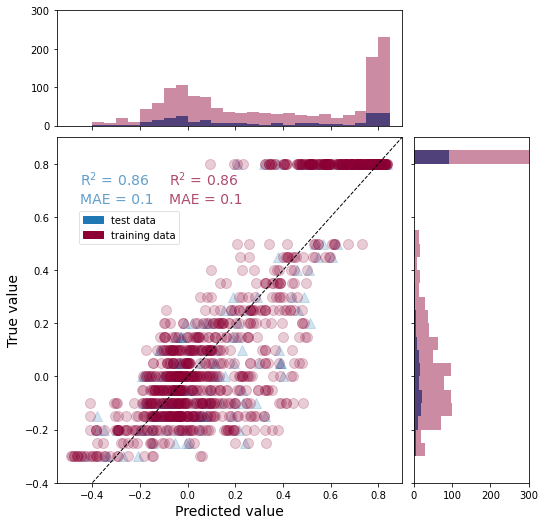

In [ ]:
from sklearn.linear_model import Lasso
regr_ard = ARDRegression(n_iter=1000,tol=1e-5,threshold_lambda=1000).fit(Xy_train.iloc[:,:-1], Xy_train.iloc[:,-1])
test_score = regr_ard.score(Xy_test.iloc[:,:-1], Xy_test.iloc[:,-1])
train_score = regr_ard.score(Xy_train.iloc[:,:-1], Xy_train.iloc[:,-1])
coef = regr_ard.coef_
intercept = regr_ard.intercept_
#print(coef, intercept)
y_predict_test_ard = regr_ard.predict(Xy_test.iloc[:,:-1])
y_predict_train_ard = regr_ard.predict(Xy_train.iloc[:,:-1])
"""
sb.set(style="white",font_scale=1)
sb.set_style("ticks",{"xtick.major.size": 6, "ytick.major.size": 6})
ax2 = sb.JointGrid(x=y_predict,y=y_test,xlim=(-0.15,1),ylim=(-0.15,1),height=7,ratio=4,marginal_ticks=True)
ax2.plot_joint(sb.regplot,n_boot=1000,color="tab:red",label="Linear fit with 95% CI",
               scatter_kws={'alpha': 0.3,'s':100})
#ax2 = sb.jointplot(y=y_predict,x=y_test,color="tab:red",height=8, ratio=2, marginal_ticks=True,alpha=0.3, s=100)
ax2.set_axis_labels(xlabel="Predicted value", ylabel="True value", fontsize=14)
ax2.plot_marginals(sb.histplot,bins=9,color="tab:red",kde=True)
"""
# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
scatter_hist(y_predict_test_ard, y_test, y_predict_train_ard, y_train, ax, ax_histx, ax_histy)
ax.annotate('MAE = {:.2}'.format(mean_absolute_error(y_test,y_predict_test_ard)),
            (-0.45,0.65),fontsize=14,color='tab:blue',alpha=0.7)
ax.annotate('R$^2$ = {:.2}'.format(test_score),
            (-0.45,0.72),fontsize=14,color='tab:blue',alpha=0.7)
ax.annotate('MAE = {:.2}'.format(mean_absolute_error(y_train,y_predict_train_ard)),
            (-0.08,0.65),fontsize=14,color='xkcd:red wine',alpha=0.7)
ax.annotate('R$^2$ = {:.2}'.format(train_score),
            (-0.08,0.72),fontsize=14,color='xkcd:red wine',alpha=0.7)
#print('R$^2$ = {:.2}'.format(score))
#print('RMSE = {:.3}'.format(mean_squared_error(y_test,y_predict,squared=False)))
plt.savefig("Linear Model/Results from linear model with H2", dpi=300, 
            bbox_inches="tight")
plt.show()

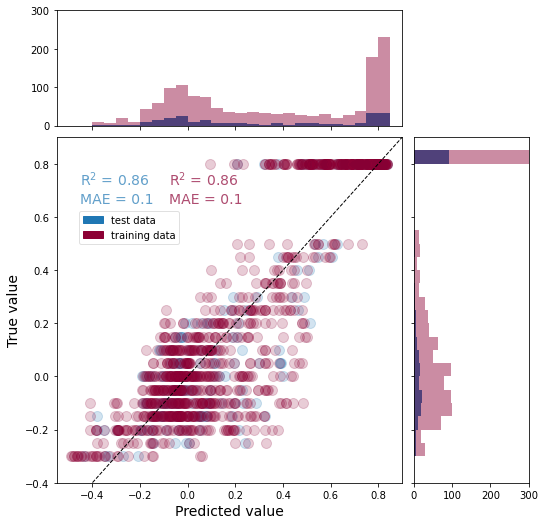

In [ ]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
scatter_hist(y_predict_test_ard, y_test, y_predict_train_ard, y_train, ax, ax_histx, ax_histy)
ax.annotate('MAE = {:.2}'.format(mean_absolute_error(y_test,y_predict_test_ard)),
            (-0.45,0.65),fontsize=14,color='tab:blue',alpha=0.7)
ax.annotate('R$^2$ = {:.2}'.format(test_score),
            (-0.45,0.72),fontsize=14,color='tab:blue',alpha=0.7)
ax.annotate('MAE = {:.2}'.format(mean_absolute_error(y_train,y_predict_train_ard)),
            (-0.08,0.65),fontsize=14,color='xkcd:red wine',alpha=0.7)
ax.annotate('R$^2$ = {:.2}'.format(train_score),
            (-0.08,0.72),fontsize=14,color='xkcd:red wine',alpha=0.7)
ax.set_xlabel("Predicted value", fontsize=14)
ax.set_ylabel("True value", fontsize=14)
ax.set_xlim((-0.55,0.9))
#print('R$^2$ = {:.2}'.format(score))
#print('RMSE = {:.3}'.format(mean_squared_error(y_test,y_predict,squared=False)))
plt.savefig("Linear Model/Results from linear model with H2", dpi=300, 
            bbox_inches="tight")
plt.show()

[0.70290669 0.47145002 0.47145002 0.23285496 0.19569342 0.19569342
 0.18004008 0.18004008 0.18004008 0.18004008]
[-1.24947256 -1.24947256 -1.04871333 -1.04871333 -0.95786744 -0.8802098
 -0.77599615 -0.77599615 -0.70652675 -0.65233601 -0.65233601 -0.64730181
 -0.64730181 -0.56427653 -0.56427653]
['pct Ni pctd8s2' 'pct Cu pctd10s0' 'pct Cu pct Pd' 'pct Cu pct Au'
 'pct Cu pct Rh' 'pct Cu pctd8s1' 'pct 11 pcttet' 'pctd10s1 pcttet'
 'pct Sn pct 11' 'pct Sn pctd10s1']
['pct Rh Ave OH binding' 'pctd8s1 Ave OH binding' 'pct Ni Ave ion energy'
 'pctd8s2 Ave ion energy' 'pct 10 Ave M-O bond' 'pct Au pct 9'
 'pct Au pctd8s1' 'pct Au pct Rh' 'pct 10 Ave ion energy'
 'pct Au pctd10s0' 'pct Pd pct Au' 'pcttet Ave work function'
 'pct Sn Ave work function' 'pct Pt pctd7s2' 'pct Pt pcthex']


C:\Users\Jeremy\AppData\Local\Temp/ipykernel_14156/1631399987.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(sorted_features_all)


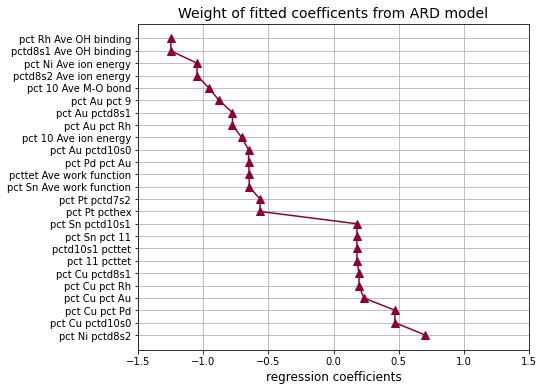

In [ ]:
#print(len(regr_tree.feature_importances_),X.columns)
features = poly.get_feature_names_out(X.columns)
features = np.where(features == '1',"constant",features)
sorted_features_ind = np.argsort(regr_ard.coef_)[::-1]
sorted_features = features[sorted_features_ind]
sorted_weights = regr_ard.coef_[sorted_features_ind]
#print(len(sorted_features),len(sorted_weights))
sorted_features_descend = sorted_features
sorted_weights_descend = sorted_weights
sorted_features_descend = sorted_features_descend[:10]
sorted_weights_descend = sorted_weights_descend[:10]
sorted_features_ascend = sorted_features[::-1]
sorted_features_ascend = sorted_features_ascend[:15]
sorted_weights_ascend = sorted_weights[::-1]
sorted_weights_ascend = sorted_weights_ascend[:15]
sorted_features_all = np.concatenate((sorted_features_descend,sorted_features_ascend[::-1]))
sorted_weights_all = np.concatenate((sorted_weights_descend,sorted_weights_ascend[::-1]))
print(sorted_weights_descend)
print(sorted_weights_ascend)
print(sorted_features_descend)
print(sorted_features_ascend)
fig, ax = plt.subplots(figsize=(7,6))
#print(sorted_weights)
ax.plot(sorted_weights_all,range(len(sorted_features_all)),marker="^",markersize=8,color='xkcd:red wine')
ax.set_yticklabels(sorted_features_all)
ax.set_xlabel("regression coefficients", fontsize=12)
plt.yticks(range(len(sorted_features_all)))
ax.xaxis.grid()
ax.yaxis.grid()
plt.xlim((-1.5,1.5))
plt.title("Weight of fitted coefficents from ARD model",fontsize=14)
plt.savefig("Linear Model/Weights from ARD model with H2", dpi=300,bbox_inches="tight")
plt.show()


## NN with Pytorch

### Cross validation

Training size 1/4
fold 1/4



fold 2/4



fold 3/4



fold 4/4



Training size 2/4
fold 1/4



fold 2/4



fold 3/4



fold 4/4



Training size 3/4
fold 1/4



fold 2/4



fold 3/4



fold 4/4



Training size 4/4
fold 1/4



fold 2/4



fold 3/4



fold 4/4


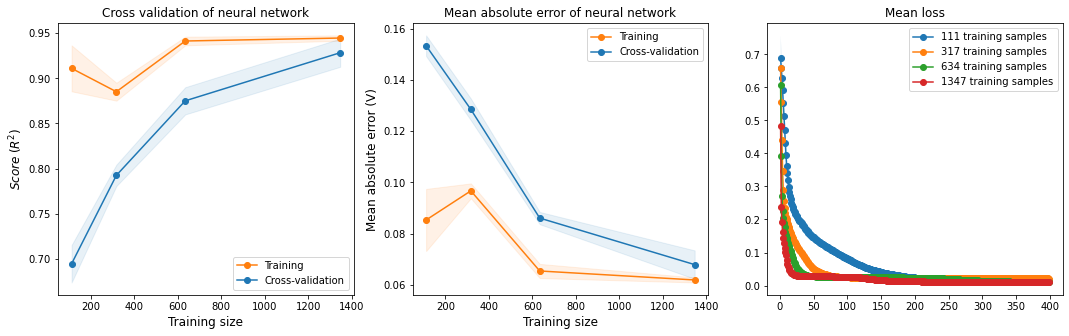

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
import numpy as np
import imageio
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold


cuda = torch.device('cuda')
torch.cuda.empty_cache()


class Train_set(torch.utils.data.Dataset):
  def __init__(self, X, y):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      self.X = torch.from_numpy(X)
      self.y = torch.from_numpy(y)
    else:
      self.X = X
      self.y = y

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]


class Net(torch.nn.Module):
    def __init__(self, n_feature):
      super(Net, self).__init__()
      self.regress = nn.Sequential(nn.Linear(n_feature, 110),nn.Dropout(p=0.1),nn.Tanh(),
                                   nn.Linear(110, 78),nn.Dropout(p=0.1),nn.Tanh(),
                                   nn.Linear(78, 35),nn.Dropout(p=0.05),nn.Tanh(),
                                   nn.Linear(35, 8),nn.Tanh(), 
                                   nn.Linear(8, 3),nn.Tanh(),
                                   nn.Linear(3,3), nn.Tanh(),
                                   nn.Linear(3, 1))

    def forward(self, x):
      return self.regress(x.float())


loss_func = torch.nn.MSELoss() 
X2 = poly.fit_transform(X)
Y = y.ravel()
training_sizes = [0.07,0.2,0.4,0.85]
folds = 4
epochs = 400
ave_r2_train, ave_r2_test = [],[]
ave_mae_train, ave_mae_test = [],[]
std_r2_train, std_r2_test = [],[]
std_mae_train, std_mae_test = [],[]
count = 0
ave_loss = []
for t in range(len(training_sizes)):
  fold_r2_train = []
  fold_mae_train = []
  fold_r2_test = []
  fold_mae_test = []
  cv = ShuffleSplit(n_splits=folds, train_size=training_sizes[t], random_state=0)
  #ave_loss.append([])
  print('Training size {}/{}'.format(t+1,len(training_sizes)))
  for i in enumerate(cv.split(range(len(Y)))):
    print('fold {}/{}'.format(i[0]+1,folds))
    X_train = X2[i[1][0],:]
    Y_train = Y[i[1][0]]
    X_test = X2[i[1][1],:]
    Y_test = Y[i[1][1]]
    x_test, y_test = torch.from_numpy(X_test.astype('float')), torch.from_numpy(Y_test)
    y_test = y_test.reshape((Y_test.shape[0], 1))
    x_train, y_train = torch.from_numpy(X_train.astype('float')), torch.from_numpy(Y_train)
    y_train = y_train.reshape((Y_train.shape[0], 1))
    torch.cuda.empty_cache()
    torch.manual_seed(1)    # reproducibility
    net = Net(n_feature=x_train.size(1))
    #net = net.float()
    net.to(cuda)

    # print(net)  # net architecture
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-5,weight_decay=1e-5) 
    train_set = Train_set(x_train,y_train)
    trainloader = DataLoader(train_set, batch_size=1, shuffle=True)
    ave_loss.append([])
    # train the network
    for tq in tqdm(range(epochs)):
      # Iterate over the DataLoader for training data
      sum_loss = 0.0
      for i, data in enumerate(trainloader, 0):
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        inputs, targets = inputs.to(cuda), targets.to(cuda)
        targets = targets.reshape((targets.shape[0], 1))
        # Zero the gradients
        optimizer.zero_grad()
        # Perform forward pass
        outputs = net(inputs)
        # Compute loss
        loss = loss_func(outputs, targets)
        # Perform backward pass
        loss.backward()
        # Perform optimization
        optimizer.step()
        sum_loss += loss.item()
      ave_loss[t].append(sum_loss/x_train.size(0))
    prediction_train = net(x_train.to(cuda))
    prediction_test = net(x_test.to(cuda))
    prediction_test = prediction_test.cpu()
    prediction_train= prediction_train.cpu()
    y_test = y_test.cpu()
    y_train = y_train.cpu()
    fold_r2_train.append(r2_score(y_train.data.numpy(),prediction_train.data.numpy()))
    fold_mae_train.append(mean_absolute_error(y_train.data.numpy(),prediction_train.data.numpy()))
    fold_r2_test.append(r2_score(y_test.data.numpy(),prediction_test.data.numpy()))
    fold_mae_test.append(mean_absolute_error(y_test.data.numpy(),prediction_test.data.numpy()))
    '''
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_axes(rect_scatter)
    ax_histx = fig.add_axes(rect_histx, sharex=ax)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)
    scatter_hist(prediction_test.data.numpy(), y_test.data.numpy(), prediction_train.data.numpy(),
                y_train.data.numpy(), ax, ax_histx, ax_histy)
    ax.annotate('R$^2$ = {:.2}'.format(r2_score(y_train.data.numpy(),
                                                prediction_train.data.numpy())),
                (-0.35,0.72),fontsize=14,color='tab:orange')
    ax.annotate('MAE = {:.2}'.format(mean_absolute_error(y_train.data.numpy(),
                                                        prediction_train.data.numpy())),
                (-0.35,0.68),fontsize=14,color='tab:orange')
    ax.annotate('R$^2$ = {:.2}'.format(r2_score(y_test.data.numpy(),
                                                prediction_test.data.numpy())),
                (0.05,0.72),fontsize=14,color='tab:blue')
    ax.annotate('MAE = {:.2}'.format(mean_absolute_error(y_test.data.numpy(),
                                                        prediction_test.data.numpy())),
                (0.05,0.68),fontsize=14,color='tab:blue')
    ax.set_xlabel("Predicted value")
    ax.set_ylabel("True value") 
    fig2 = plt.figure(figsize=(25, 8))
    plt.plot(range(len(CL)),CL)
    plt.xlim((-5,len(CL)+5))
    '''
    #plt.show()
  ave_r2_train.append(np.mean(fold_r2_train))
  ave_mae_train.append(np.mean(fold_mae_train))
  ave_r2_test.append(np.mean(fold_r2_test))
  ave_mae_test.append(np.mean(fold_mae_test))
  std_r2_train.append(np.std(fold_r2_train))
  std_mae_train.append(np.std(fold_mae_train))
  std_r2_test.append(np.std(fold_r2_test))
  std_mae_test.append(np.std(fold_mae_test))
  fold_r2_train, fold_r2_test = [],[]
  fold_mae_train, fold_mae_test = [],[]
train_sizes = []
train_scores_std, test_scores_std = [],[]
for i in range(len(training_sizes)):
  train_sizes.append(ceil(training_sizes[i]*len(Y)))
#print(ave_r2_train,ave_r2_test,ave_mae_train,ave_mae_test)
ave_ave_loss, std_ave_loss = [], []
for ggg in range(len(train_sizes)):
  ave_ave_loss.append([])
  std_ave_loss.append([])
  for g in range(epochs-1):
    ave_ave_loss[ggg].append(np.mean([ave_loss[ggg][g+u*epochs] for u in range(folds)]))
    std_ave_loss[ggg].append(np.std([ave_loss[ggg][g+u*epochs] for u in range(folds)]))
_, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].set_title("Cross validation of neural network",fontsize=12)
axes[0].fill_between(
        train_sizes,
        [np.subtract(x[0],x[1]) for x in zip(ave_r2_train, std_r2_train)],
        [sum(x) for x in zip(ave_r2_train, std_r2_train)],
        alpha=0.1,
        color="tab:orange"
        )
axes[0].fill_between(
        train_sizes,
        [np.subtract(x[0],x[1]) for x in zip(ave_r2_test, std_r2_test)],
        [sum(x) for x in zip(ave_r2_test, std_r2_test)],
        alpha=0.1,
        color="tab:blue"
        )
axes[0].plot(train_sizes,ave_r2_train,"o-",color='tab:orange',ms=12,label="Training")
axes[0].set_ylabel("$Score\;(R^2)$",fontsize=12)
axes[0].set_xlabel("Training size",fontsize=12)
axes[0].plot(train_sizes,ave_r2_test,"^-",color='tab:blue',ms=12,label="Cross-validation")
axes[0].legend(loc='lower right')
#axes[0].set_ylim(0.65,1.02)

axes[1].set_title("Mean absolute error of neural network",fontsize=12)
axes[1].fill_between(
        train_sizes,
        [np.subtract(x[0],x[1]) for x in zip(ave_mae_train, std_mae_train)],
        [sum(x) for x in zip(ave_mae_train, std_mae_train)],
        alpha=0.1,
        color="tab:orange"
        )
axes[1].fill_between(
        train_sizes,
        [np.subtract(x[0],x[1]) for x in zip(ave_mae_test, std_mae_test)],
        [sum(x) for x in zip(ave_mae_test, std_mae_test)],
        alpha=0.1,
        color="tab:blue"
        )
axes[1].plot(train_sizes,ave_mae_train,"o-",color='tab:orange',ms=12,label="Training")
axes[1].set_ylabel("Mean absolute error (V)",fontsize=12)
axes[1].set_xlabel("Training size",fontsize=12)
axes[1].plot(train_sizes,ave_mae_test,"^-",color='tab:blue',ms=12,label="Cross-validation")
axes[1].legend(loc='upper right')
axes[2].set_title("Mean Loss over 4-folds",fontsize=12)
mrks = ["","^","x","."]
for b in range(len(train_sizes)):
  axes[2].fill_between(
          range(1,epochs-300),
          [np.subtract(x[0],x[1]) for x in zip(ave_ave_loss[b][:-300], std_ave_loss[b][:-300])],
          [sum(x) for x in zip(ave_ave_loss[b][:-300], std_ave_loss[b][:-300])],
          alpha=0.1,
          )
  axes[2].plot(range(1,epochs-300),ave_ave_loss[b][:-300],marker=mrks[b],ms=7,label=str(ceil(training_sizes[b]*len(Y)))+" training samples")
axes[2].legend(loc="upper right")
axes[2].set_ylim(0.0,0.75)
axes[2].set_ylabel("Mean Loss",fontsize=12)
axes[2].set_xlabel("Number of epochs",fontsize=12)
plt.savefig("Neural Network/Learning metrics NN pytorch interpolate new.png", dpi=300,bbox_inches="tight")
plt.show()

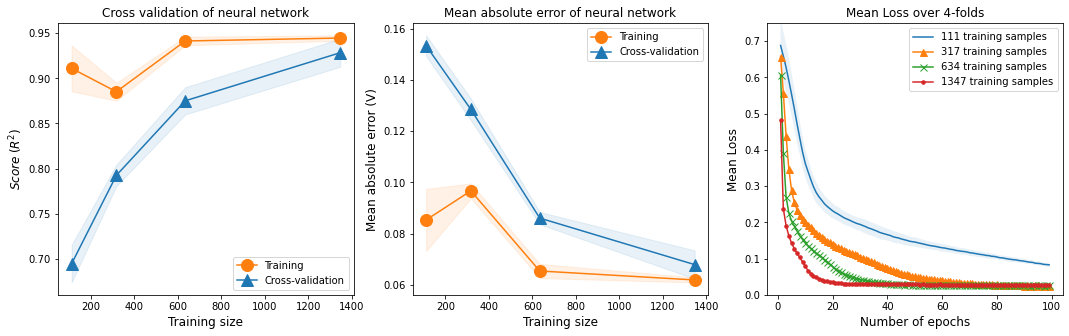

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].set_title("Cross validation of neural network",fontsize=12)
axes[0].fill_between(
        train_sizes,
        [np.subtract(x[0],x[1]) for x in zip(ave_r2_train, std_r2_train)],
        [sum(x) for x in zip(ave_r2_train, std_r2_train)],
        alpha=0.1,
        color="tab:orange"
        )
axes[0].fill_between(
        train_sizes,
        [np.subtract(x[0],x[1]) for x in zip(ave_r2_test, std_r2_test)],
        [sum(x) for x in zip(ave_r2_test, std_r2_test)],
        alpha=0.1,
        color="tab:blue"
        )
axes[0].plot(train_sizes,ave_r2_train,"o-",color='tab:orange',ms=12,label="Training")
axes[0].set_ylabel("$Score\;(R^2)$",fontsize=12)
axes[0].set_xlabel("Training size",fontsize=12)
axes[0].plot(train_sizes,ave_r2_test,"^-",color='tab:blue',ms=12,label="Cross-validation")
axes[0].legend(loc='lower right')
#axes[0].set_ylim(0.65,1.02)

axes[1].set_title("Mean absolute error of neural network",fontsize=12)
axes[1].fill_between(
        train_sizes,
        [np.subtract(x[0],x[1]) for x in zip(ave_mae_train, std_mae_train)],
        [sum(x) for x in zip(ave_mae_train, std_mae_train)],
        alpha=0.1,
        color="tab:orange"
        )
axes[1].fill_between(
        train_sizes,
        [np.subtract(x[0],x[1]) for x in zip(ave_mae_test, std_mae_test)],
        [sum(x) for x in zip(ave_mae_test, std_mae_test)],
        alpha=0.1,
        color="tab:blue"
        )
axes[1].plot(train_sizes,ave_mae_train,"o-",color='tab:orange',ms=12,label="Training")
axes[1].set_ylabel("Mean absolute error (V)",fontsize=12)
axes[1].set_xlabel("Training size",fontsize=12)
axes[1].plot(train_sizes,ave_mae_test,"^-",color='tab:blue',ms=12,label="Cross-validation")
axes[1].legend(loc='upper right')
axes[2].set_title("Mean Loss over 4-folds",fontsize=12)
mrks = ["","^","x","."]
for b in range(len(train_sizes)):
  axes[2].fill_between(
          range(1,epochs-300),
          [np.log(np.subtract(x[0],x[1])) for x in zip(ave_ave_loss[b][:-300], std_ave_loss[b][:-300])],
          [np.log(sum(x)) for x in zip(ave_ave_loss[b][:-300], std_ave_loss[b][:-300])],
          alpha=0.1,
          )
  axes[2].plot(range(1,epochs-300),np.log(ave_ave_loss[b][:-300]),marker=mrks[b],ms=7,label=str(ceil(training_sizes[b]*len(Y)))+" training samples")
axes[2].legend(loc="upper right")
axes[2].set_ylim(0.0,0.75)
axes[2].set_ylabel("Mean Loss",fontsize=12)
axes[2].set_xlabel("Number of epochs",fontsize=12)
plt.savefig("Neural Network/Learning metrics NN pytorch interpolate new.png", dpi=300,bbox_inches="tight")
plt.show()

### Training model once

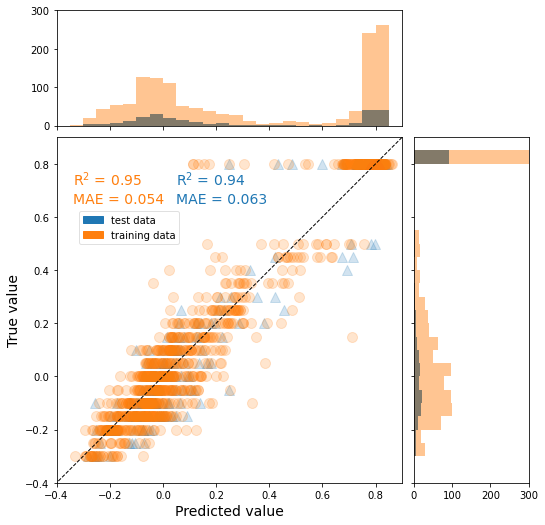

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm
import numpy as np
import imageio
from sklearn.metrics import r2_score


cuda = torch.device('cuda')
torch.cuda.empty_cache()

class Train_set(torch.utils.data.Dataset):
  def __init__(self, X, y):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      self.X = torch.from_numpy(X)
      self.y = torch.from_numpy(y)
    else:
      self.X = X
      self.y = y

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]


class Net(torch.nn.Module):
    def __init__(self, n_feature):
      super(Net, self).__init__()
      self.regress = nn.Sequential(nn.Linear(n_feature, 110),nn.Dropout(p=0.1),nn.Tanh(),
                                   nn.Linear(110, 78),nn.Dropout(p=0.1),nn.Tanh(),
                                   nn.Linear(78, 35),nn.Dropout(p=0.05),nn.Tanh(),
                                   nn.Linear(35, 8),nn.Tanh(), 
                                   nn.Linear(8, 3),nn.Tanh(),
                                   nn.Linear(3,3), nn.Tanh(),
                                   nn.Linear(3, 1))

    def forward(self, x):
      return self.regress(x.float())


x_test, y_test = torch.from_numpy(X_test.astype('float')), torch.from_numpy(y_test)
y_test = y_test.reshape((y_test.shape[0], 1))
x_train, y_train = torch.from_numpy(X_train.astype('float')), torch.from_numpy(y_train)
y_train = y_train.reshape((y_train.shape[0], 1))
torch.cuda.empty_cache()
torch.manual_seed(1)    # reproducibility
net = Net(n_feature=x_train.size(1))
#net = net.float()
net.to(cuda)
loss_func = torch.nn.MSELoss()
# print(net)  # net architecture
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5,weight_decay=1e-5)
train_set = Train_set(x_train,y_train)
trainloader = DataLoader(train_set, batch_size=1, shuffle=True)
ave_loss = []
# train the network
for t in tqdm(range(1000)):
  # Iterate over the DataLoader for training data
  sum_loss = 0.0
  for i, data in enumerate(trainloader, 0):
      # Get and prepare inputs
      inputs, targets = data
      inputs, targets = inputs.float(), targets.float()
      inputs, targets = inputs.to(cuda), targets.to(cuda)
      targets = targets.reshape((targets.shape[0], 1))
      # Zero the gradients
      optimizer.zero_grad()
      # Perform forward pass
      outputs = net(inputs)
      # Compute loss
      loss = loss_func(outputs, targets)
      # Perform backward pass
      loss.backward()
      # Perform optimization
      optimizer.step()
      sum_loss += loss.item()
  ave_loss.append(sum_loss/x_train.size(0))


prediction_train = net(x_train.to(cuda))
prediction_test = net(x_test.to(cuda))
prediction_test = prediction_test.cpu()
prediction_train= prediction_train.cpu()
y_test = y_test.cpu()
y_train = y_train.cpu()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
scatter_hist(prediction_test.data.numpy(), y_test.data.numpy(), prediction_train.data.numpy(),
            y_train.data.numpy(), ax, ax_histx, ax_histy)
ax.annotate('R$^2$ = {:.2}'.format(r2_score(y_train.data.numpy(),
                                            prediction_train.data.numpy())),
            (-0.34,0.72),fontsize=14,color='tab:orange')
ax.annotate('MAE = {:.2}'.format(mean_absolute_error(y_train.data.numpy(),
                                                    prediction_train.data.numpy())),
            (-0.34,0.65),fontsize=14,color='tab:orange')
ax.annotate('R$^2$ = {:.2}'.format(r2_score(y_test.data.numpy(),
                                            prediction_test.data.numpy())),
            (0.05,0.72),fontsize=14,color='tab:blue')
ax.annotate('MAE = {:.2}'.format(mean_absolute_error(y_test.data.numpy(),
                                                    prediction_test.data.numpy())),
            (0.05,0.65),fontsize=14,color='tab:blue')

plt.savefig("Neural Network/Results from Pytorch nn model.png", dpi=300,bbox_inches="tight")
plt.show()

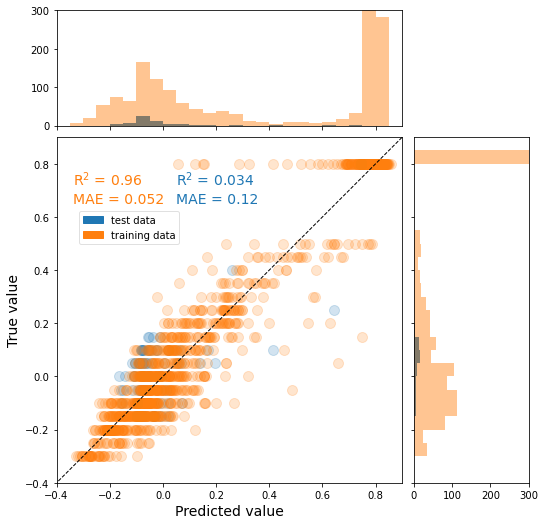

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
scatter_hist(prediction_test.data.numpy(), y_test.data.numpy(), prediction_train.data.numpy(),
            y_train.data.numpy(), ax, ax_histx, ax_histy)

ax.annotate('R$^2$ = {:.2}'.format(r2_score(y_train.data.numpy(),
                                            prediction_train.data.numpy())),
            (-0.34,0.72),fontsize=14,color='tab:orange')
ax.annotate('MAE = {:.2}'.format(mean_absolute_error(y_train.data.numpy(),
                                                    prediction_train.data.numpy())),
            (-0.34,0.65),fontsize=14,color='tab:orange')

#ax.annotate('SnPtRh',
#            (-0.25,0.72),fontsize=14,color='tab:blue')

ax.annotate('R$^2$ = {:.2}'.format(r2_score(y_test.data.numpy(),
                                            prediction_test.data.numpy())),
            (0.05,0.72),fontsize=14,color='tab:blue')
ax.annotate('MAE = {:.2}'.format(mean_absolute_error(y_test.data.numpy(),
                                                    prediction_test.data.numpy())),
            (0.05,0.65),fontsize=14,color='tab:blue')
ax.set_xlabel("Predicted value")
ax.set_ylabel("True value")
plt.savefig("Neural Network/Results from Pytorch nn model.png", dpi=300,bbox_inches="tight")
plt.show()

In [ ]:
# Save the prediction data to an excel file
elements = ["Sn","Pt","Rh"]
SID = []
PCT = np.zeros((3,66))
count = 0
for i in range(11):
  for j in range(11-i):
    Sample_ID = elements[0] + str(i) + elements[1] + str(10-j-i) + elements[2] + str(j)
    SID.append(Sample_ID)
    PCT[:,count] = [i/10.0, (10-i-j)/10.0, j/10.0]
    count+=1
temp = pd.Series(SID,name="Sample ID")
temp2 = pd.DataFrame(PCT.T,index=temp.index,columns=["Percent A","Percent B","Percent C"])
df = pd.concat((temp,temp2.astype("float")),axis=1)
df["Onset potential H2 Ag/AgCl"] = prediction_test.detach().numpy()
fig = px.scatter_ternary(temp2, a="Percent A", b="Percent B", c="Percent C", range_color=[-0.4,0.8],
    color=df["Onset potential H2 Ag/AgCl"],size=6*(df["Onset potential H2 Ag/AgCl"]+300), size_max=16, 
    color_continuous_scale=["yellow","greenyellow","cornflowerblue","indigo","black"])
fig.show()
df.to_excel('Neural Network/{} NN prediction.xls'.format(elements[0]+elements[1]+elements[2]))
#display(df)

C:\Users\Jeremy\AppData\Local\Temp/ipykernel_5484/2551132298.py:20: FutureWarning:

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.



## Def kde plot

In [ ]:
# This function will create a 2D histogram to be used for visualtion of features below
def kde_hist(x1, y1, ax, ax_histx, ax_histy):
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x1[y1==0.8], y1[y1==0.8],alpha=0.15,s=100,color='tab:red',label='Test data')
    ax.scatter(x1[y1!=0.8], y1[y1!=0.8],alpha=0.15,s=100,color='tab:blue',label='Test data')
    
    xbinwidth = np.abs((np.max(x1)-np.min(x1))/45.0)
    ybinwidth = np.abs((np.max(y1)-np.min(y1))/45.0)
    xbins = np.arange(np.min(x1)-xbinwidth, np.max(x1)+xbinwidth, xbinwidth)
    ybins = np.arange(np.min(y1)-ybinwidth, np.max(y1)+ybinwidth, ybinwidth)
    ax_histx.hist(x1[y1!=0.8], bins=xbins,alpha=0.8,color='tab:blue')
    ax_histx.hist(x1[y1==0.8], bins=xbins,alpha=0.7,color='tab:red')
    ax_histy.hist(y1[y1!=0.8], bins=ybins,alpha=0.8, orientation='horizontal',color='tab:blue')
    ax_histy.hist(y1[y1==0.8], bins=ybins,alpha=0.7, orientation='horizontal',color='tab:red')
    #ax_histx.set_yticks([0,50, 100, 150, 200,250])
    ax_histy.set_xticks([0,150, 300, 450, 600])


# definitions for the axes
left, width = 0.1, 0.6
bottom, height = 0.1, 0.6
spacing = 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

## Contribution of top features

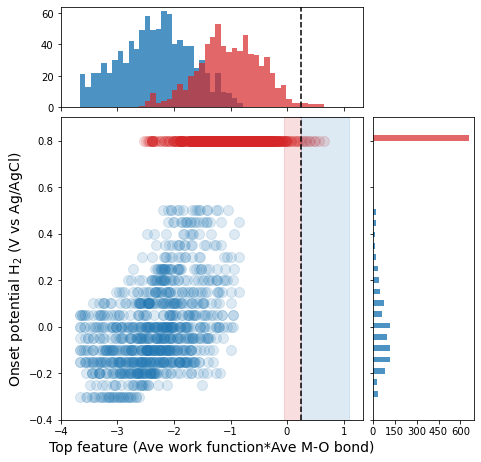

In [ ]:
fig = plt.figure(figsize=(7, 7))
#sb.kdeplot(x=df4["pct Rh"]*df4["1/pct Pt"],y=df4["Onset potential H2 Ag/AgCl"],
#        fill=True)
ax1 = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax1)
ax_histy = fig.add_axes(rect_histy, sharey=ax1)
#kde_hist((df4["pct Rh"]*df4["1/pct Pt"]+df4['pctd9s1']*df4['1/pctd8s1']+df4['pctd10s0']*df4['1/pct Cu']+df4['pct Rh']*df4['1/pctd9s1'])/4,
#         df4["Onset potential H2 Ag/AgCl"], ax1, ax_histx, ax_histy)
kde_hist(-6*df4["Ave work function"]*df4["Ave M-O bond"]+df4["Ave reduction potential"]*df4["Ave ion energy"]-\
         df4["Ave reduction potential"]*df4["Ave M-O bond"]*0.5,
         df4["Onset potential H2 Ag/AgCl"], ax1, ax_histx, ax_histy)
ax1.set_ylabel("Onset potential H$_2$ (V vs Ag/AgCl)",fontsize=14)
ax1.set_xlabel("Top feature (Ave work function*Ave M-O bond)",fontsize=14)
ax1.fill_betweenx( [-0.4,0.9],[0.25,0.25],[-0.05,-0.05],
                 color='tab:red',       # The outline color
                 alpha=0.15)          # Transparency of the fill
ax1.fill_betweenx( [-0.4,0.9],[0.25,0.25],[1.1,1.1],
                 color='tab:blue',       # The outline color
                 alpha=0.15)          # Transparency of the fill
ax_histx.axvline(x=0.25,c='black',linestyle='--')
#plt.title('Onset of H$_2$ vs. electronegativity',fontsize=16, fontweight="bold")
ax1.axvline(x=0.25,c='black',linestyle='--')
ax1.set_ylim(-0.4,0.9)
#ax1.set_xlim(-0.02,0.68)
plt.savefig("Random Forest/Onset H2 vs Top feature", dpi=300, 
           bbox_inches="tight")
plt.show()

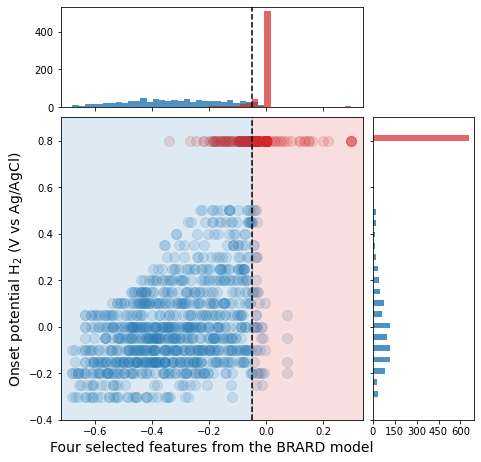

In [ ]:
fig = plt.figure(figsize=(7, 7))
#sb.kdeplot(x=df4["pct Rh"]*df4["1/pct Pt"],y=df4["Onset potential H2 Ag/AgCl"],
#        fill=True)
ax1 = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax1)
ax_histy = fig.add_axes(rect_histy, sharey=ax1)
kde_hist(-(df4["pct Rh"]*df4["Ave OH binding"])-(df4["pct Ni"]*df4["Ave ion energy"])-\
          (df4["pct 10"]*df4["Ave M-O bond"])+(df4["pctd8s2"]*df4["pct Ni"]),
         df4["Onset potential H2 Ag/AgCl"], ax1, ax_histx, ax_histy)
ax1.set_ylabel("Onset potential H$_2$ (V vs Ag/AgCl)",fontsize=14)
ax1.set_xlabel("Four selected features from the BRARD model",fontsize=14)

ax1.fill_betweenx( [-0.4,0.9],[-0.05,-0.05],[0.34,0.34],
                 color='tab:red',       # The outline color
                 alpha=0.15)          # Transparency of the fill
ax1.fill_betweenx( [-0.4,0.9],[-0.05,-0.05],[-0.72,-0.72],
                 color='tab:blue',       # The outline color
                 alpha=0.15)          # Transparency of the fill
ax_histx.axvline(x=-0.05,c='black',linestyle='--')
ax1.axvline(x=-0.05,c='black',linestyle='--')
ax1.set_ylim(-0.4,0.9)
ax1.set_xlim(-0.72,0.34)
plt.savefig("Linear Model/Onset H2 vs Top features ARD", dpi=300, 
           bbox_inches="tight")
plt.show()

## Onset H2 vs ave ionization energy

### H$_2$

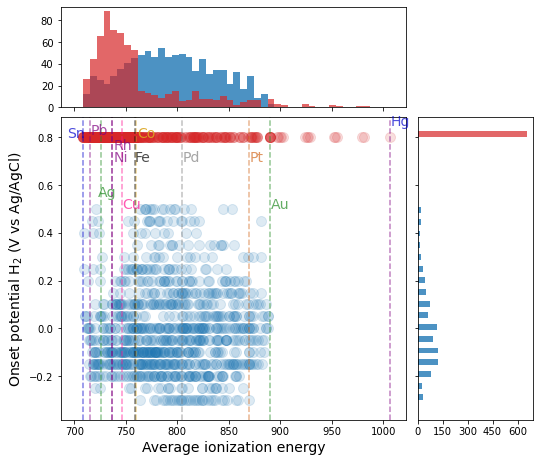

In [ ]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax1)
ax_histy = fig.add_axes(rect_histy, sharey=ax1)
kde_hist(df3["Ave ion energy"],df3["Onset potential H2 Ag/AgCl"], ax1,
         ax_histx, ax_histy)
ax1.set_ylabel("Onset potential H$_2$ (V vs Ag/AgCl)",fontsize=14)
ax1.set_xlabel("Average ionization energy",fontsize=14)
#plt.title('Onset of H$_2$ vs. Ionization energy',fontsize=16, fontweight="bold")
ax1.axvline(x=870,c='chocolate',linestyle='--',alpha=0.5)
ax1.annotate('Pt',(870,0.7),c='chocolate',fontsize=14,alpha=0.7)
ax1.axvline(x=805, c='grey',linestyle='--',alpha=0.5)
ax1.annotate('Pd',(805,0.7),c='grey',fontsize=14,alpha=0.7)
ax1.axvline(x=760, c='goldenrod',linestyle='--',alpha=0.5)
ax1.annotate('Co',(761,0.8),c='goldenrod',fontsize=14,alpha=0.9)
ax1.axvline(x=759, c='black',linestyle='--',alpha=0.5)
ax1.annotate('Fe',(759,0.7),c='black',fontsize=14,alpha=0.7)
ax1.axvline(x=708.6, c='mediumblue',linestyle='--',alpha=0.5)
ax1.annotate('Sn',(693,0.8),c='mediumblue',fontsize=14,alpha=0.7)
ax1.axvline(x=715.6, c='purple',linestyle='--',alpha=0.5)
ax1.annotate('Pb',(716,0.81),c='purple',fontsize=14,alpha=0.7)
ax1.axvline(x=737.1, c='purple',linestyle='--',alpha=0.5)
ax1.annotate('Rh',(738,0.75),c='purple',fontsize=14,alpha=0.7)
ax1.axvline(x=1007, c='purple',linestyle='--',alpha=0.5)
ax1.annotate('Hg',(1007.5,0.85),c='mediumblue',fontsize=14,alpha=0.7)
ax1.axvline(x=737.1, c='purple',linestyle='--',alpha=0.5)
ax1.annotate('Ni',(738,0.7),c='purple',fontsize=14,alpha=0.7)
ax1.axvline(x=890.1, c='forestgreen',linestyle='--',alpha=0.5)
ax1.annotate('Au',(891,0.5),c='forestgreen',fontsize=14,alpha=0.7)
ax1.axvline(x=726, c='forestgreen',linestyle='--',alpha=0.5)
ax1.annotate('Ag',(723,0.55),c='forestgreen',fontsize=14,alpha=0.7)
ax1.axvline(x=746, c='deeppink',linestyle='--',alpha=0.5)
ax1.annotate('Cu',(746.2,0.5),c='deeppink',fontsize=14,alpha=0.7)
#ax1.set_xlim(710,890)
plt.savefig("Onset H2 vs ionization energy", dpi=300, 
            bbox_inches="tight")
plt.show()

## Onset H2 vs ave electronegativity



### H2

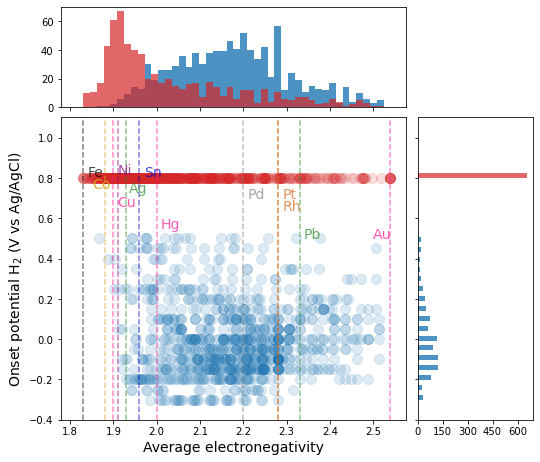

In [ ]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax1)
ax_histy = fig.add_axes(rect_histy, sharey=ax1)
kde_hist(df3["Ave electronegativity"],df3["Onset potential H2 Ag/AgCl"], ax1,
         ax_histx, ax_histy)

ax1.set_ylabel("Onset potential H$_2$ (V vs Ag/AgCl)",fontsize=14)
ax1.set_xlabel("Average electronegativity",fontsize=14)
ax1.axvline(x=2.28,c='chocolate',linestyle='--',alpha=0.5)
ax1.annotate('Pt',(2.29,0.7),c='chocolate',fontsize=14,alpha=0.7)
ax1.axvline(x=2.2, c='grey',linestyle='--',alpha=0.5)
ax1.annotate('Pd',(2.21,0.7),c='grey',fontsize=14,alpha=0.7)
ax1.axvline(x=1.88, c='goldenrod',linestyle='--',alpha=0.5)
ax1.annotate('Co',(1.85,0.75),c='goldenrod',fontsize=14,alpha=0.9)
ax1.axvline(x=1.83, c='black',linestyle='--',alpha=0.5)
ax1.annotate('Fe',(1.84,0.81),c='black',fontsize=14,alpha=0.7)
ax1.axvline(x=1.96, c='mediumblue',linestyle='--',alpha=0.5)
ax1.annotate('Sn',(1.97,0.81),c='mediumblue',fontsize=14,alpha=0.7)
ax1.axvline(x=1.91, c='purple',linestyle='--',alpha=0.5)
ax1.annotate('Ni',(1.91,0.82),c='purple',fontsize=14,alpha=0.7)
ax1.axvline(x=2.33, c='forestgreen',linestyle='--',alpha=0.5)
ax1.annotate('Pb',(2.34,0.5),c='forestgreen',fontsize=14,alpha=0.7)
ax1.axvline(x=1.93, c='forestgreen',linestyle='--',alpha=0.5)
ax1.annotate('Ag',(1.935,0.73),c='forestgreen',fontsize=14,alpha=0.7)
ax1.axvline(x=1.9, c='deeppink',linestyle='--',alpha=0.5)
ax1.annotate('Cu',(1.91,0.66),c='deeppink',fontsize=14,alpha=0.7)
ax1.axvline(x=2.54, c='deeppink',linestyle='--',alpha=0.5)
ax1.annotate('Au',(2.5,0.5),c='deeppink',fontsize=14,alpha=0.7)
ax1.axvline(x=2.28, c='chocolate',linestyle='--',alpha=0.5)
ax1.annotate('Rh',(2.29,0.64),c='chocolate',fontsize=14,alpha=0.7)
ax1.axvline(x=2, c='deeppink',linestyle='--',alpha=0.5)
ax1.annotate('Hg',(2.01,0.55),c='deeppink',fontsize=14,alpha=0.7)
#ax1.set_xlim(1.45,2.6)
ax1.set_ylim(-0.4,1.1)
plt.savefig("Onset H2 vs electronegativity", dpi=300, 
          bbox_inches="tight")

plt.show()

## Onset H2 vs ave H binding energy

### H2

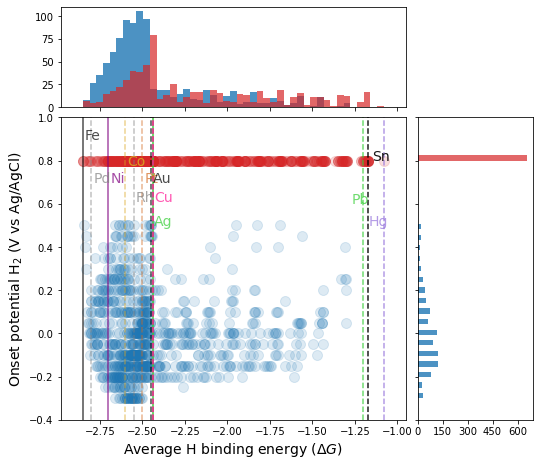

In [ ]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax1)
ax_histy = fig.add_axes(rect_histy, sharey=ax1)
kde_hist(df3["Ave H binding"],df3["Onset potential H2 Ag/AgCl"], ax1,
         ax_histx, ax_histy)

ax1.set_ylabel("Onset potential H$_2$ (V vs Ag/AgCl)",fontsize=14)
ax1.set_xlabel("Average H binding energy ($\Delta G$)",fontsize=14)
ax1.axvline(x=-2.5,c='chocolate',linestyle='--',alpha=0.5)
ax1.annotate('Pt',(-2.49,0.7),c='chocolate',fontsize=14,alpha=0.7)
ax1.axvline(x=-2.8, c='grey',linestyle='--',alpha=0.5)
ax1.annotate('Pd',(-2.79,0.7),c='grey',fontsize=14,alpha=0.7)
ax1.axvline(x=-2.6, c='goldenrod',linestyle='--',alpha=0.5)
ax1.annotate('Co',(-2.59,0.78),c='goldenrod',fontsize=14,alpha=0.9)
ax1.axvline(x=-2.85, c='black',linestyle='-',alpha=0.7)
ax1.annotate('Fe',(-2.84,0.9),c='black',fontsize=14,alpha=0.7)
ax1.axvline(x=-1.17, c='black',linestyle='--',alpha=0.9)
ax1.annotate('Sn',(-1.15,0.8),c='black',fontsize=14,alpha=0.9)
ax1.axvline(x=-2.7, c='purple',linestyle='-',alpha=0.7)
ax1.annotate('Ni',(-2.69,0.7),c='purple',fontsize=14,alpha=0.7)
ax1.axvline(x=-1.2, c='limegreen',linestyle='--',alpha=0.7)
ax1.annotate('Pb',(-1.27,0.6),c='limegreen',fontsize=14,alpha=0.7)
ax1.axvline(x=-2.44, c='limegreen',linestyle='-',alpha=0.95)
ax1.annotate('Ag',(-2.43,0.5),c='limegreen',fontsize=14,alpha=0.7)
ax1.axvline(x=-2.44, c='deeppink',linestyle='--',alpha=1)
ax1.annotate('Cu',(-2.43,0.61),c='deeppink',fontsize=14,alpha=0.7)
ax1.axvline(x=-2.45, c='black',linestyle='--',alpha=0.7)
ax1.annotate('Au',(-2.44,0.7),c='black',fontsize=14,alpha=0.7)
ax1.axvline(x=-2.55, c='grey',linestyle='--',alpha=0.5)
ax1.annotate('Rh',(-2.54,0.61),c='grey',fontsize=14,alpha=0.7)
ax1.axvline(x=-1.08, c='mediumpurple',linestyle='--',alpha=0.7)
ax1.annotate('Hg',(-1.17,0.5),c='mediumpurple',fontsize=14,alpha=0.7)

#ax1.set_xlim(-2.95,-2.4)
ax1.set_ylim(-0.4,1)
plt.savefig("Onset H2 vs Ave H binding energy", dpi=300, 
           bbox_inches="tight")
plt.show()

## Onset H2 vs ave OH binding energy

Ag3Cu3Hg4
dropped 264
dropped 265
dropped 266
dropped 267
dropped 268
dropped 269
dropped 270
dropped 271
dropped 272
dropped 273
dropped 274
dropped 275
dropped 276
dropped 277
dropped 278
dropped 279
dropped 280
dropped 281
dropped 282
dropped 283
dropped 284
dropped 285
dropped 286
dropped 287
dropped 288
dropped 289
dropped 290
dropped 291
dropped 292
dropped 293
dropped 294
dropped 295
dropped 296
dropped 297
dropped 298
dropped 299
dropped 300
dropped 301
dropped 302
dropped 303
dropped 304
dropped 305
dropped 306
dropped 307
dropped 308
dropped 309
dropped 310
dropped 311
dropped 312
dropped 313
dropped 314
dropped 315
dropped 316
dropped 317
dropped 318
dropped 319
dropped 320
dropped 321
dropped 322
dropped 323
dropped 324
dropped 325
dropped 326
dropped 327
dropped 328
dropped 329


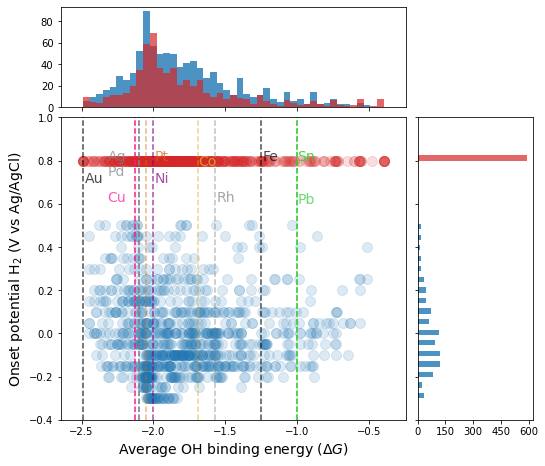

In [ ]:
df3_noHg = df3.copy()
print(df3_noHg['Sample ID'].iloc[298])
sampleid = df3_noHg['Sample ID']
for i in range(len(df3_noHg.index)-1):
  if 'Hg' in sampleid[i]:
    df3_noHg.drop(i,axis=0,inplace=True)
    print('dropped',i)
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax1)
ax_histy = fig.add_axes(rect_histy, sharey=ax1)
kde_hist(df3_noHg["Ave OH binding"],df3_noHg["Onset potential H2 Ag/AgCl"], ax1,
         ax_histx, ax_histy)

ax1.set_ylabel("Onset potential H$_2$ (V vs Ag/AgCl)",fontsize=14)
ax1.set_xlabel("Average OH binding energy ($\Delta G$)",fontsize=14)

ax1.axvline(x=-2.05,c='chocolate',linestyle='--',alpha=0.5)
ax1.annotate('Pt',(-1.99,0.8),c='chocolate',fontsize=14,alpha=0.7)
ax1.axvline(x=-2.1, c='grey',linestyle='--',alpha=0.5)
ax1.annotate('Pd',(-2.32,0.73),c='grey',fontsize=14,alpha=0.7)
ax1.axvline(x=-1.69, c='goldenrod',linestyle='--',alpha=0.5)
ax1.annotate('Co',(-1.69,0.78),c='goldenrod',fontsize=14,alpha=0.9)
ax1.axvline(x=-1.25, c='black',linestyle='--',alpha=0.7)
ax1.annotate('Fe',(-1.24,0.8),c='black',fontsize=14,alpha=0.7)
ax1.axvline(x=-1, c='limegreen',linestyle='--',alpha=0.9)
ax1.annotate('Sn',(-1,0.8),c='limegreen',fontsize=14,alpha=0.9)
ax1.axvline(x=-2, c='purple',linestyle='--',alpha=0.7)
ax1.annotate('Ni',(-1.99,0.7),c='purple',fontsize=14,alpha=0.7)
ax1.axvline(x=-1, c='limegreen',linestyle='--',alpha=0.7)
ax1.annotate('Pb',(-1,0.6),c='limegreen',fontsize=14,alpha=0.7)
ax1.axvline(x=-2.1, c='grey',linestyle='--',alpha=0.95)
ax1.annotate('Ag',(-2.32,0.8),c='grey',fontsize=14,alpha=0.7)
ax1.axvline(x=-2.13, c='deeppink',linestyle='--',alpha=1)
ax1.annotate('Cu',(-2.32,0.61),c='deeppink',fontsize=14,alpha=0.7)
ax1.axvline(x=-2.49, c='black',linestyle='--',alpha=0.7)
ax1.annotate('Au',(-2.48,0.7),c='black',fontsize=14,alpha=0.7)
ax1.axvline(x=-1.57, c='grey',linestyle='--',alpha=0.5)
ax1.annotate('Rh',(-1.56,0.61),c='grey',fontsize=14,alpha=0.7)
#ax1.axvline(x=2, c='mediumpurple',linestyle='--',alpha=0.7)
#ax1.annotate('Hg',(2,0.5),c='mediumpurple',fontsize=14,alpha=0.7)

#ax1.set_xlim(-2.95,-2.4)
ax1.set_ylim(-0.4,1)
plt.savefig("Onset H2 vs Ave OH binding energy", dpi=300, 
           bbox_inches="tight")
plt.show()

## Onset H2 vs ave reduction potential

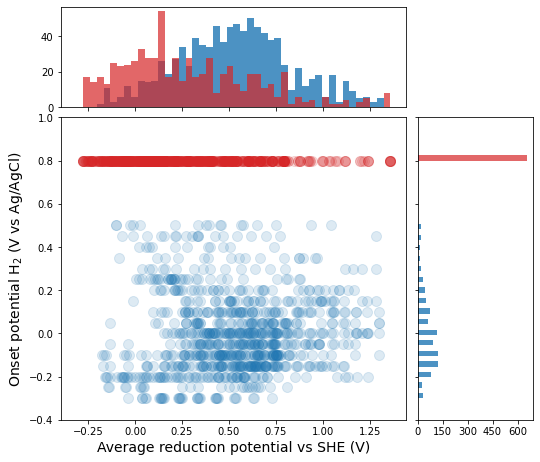

In [ ]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax1)
ax_histy = fig.add_axes(rect_histy, sharey=ax1)
kde_hist(df3["Ave reduction potential"],df3["Onset potential H2 Ag/AgCl"], ax1,
         ax_histx, ax_histy)

ax1.set_ylabel("Onset potential H$_2$ (V vs Ag/AgCl)",fontsize=14)
ax1.set_xlabel("Average reduction potential vs SHE (V)",fontsize=14)

"""
ax1.axvline(x=-2.5,c='chocolate',linestyle='--',alpha=0.5)
ax1.annotate('Pt',(-2.49,0.7),c='chocolate',fontsize=14,alpha=0.7)
ax1.axvline(x=-2.8, c='grey',linestyle='--',alpha=0.5)
ax1.annotate('Pd',(-2.79,0.7),c='grey',fontsize=14,alpha=0.7)
ax1.axvline(x=-2.6, c='goldenrod',linestyle='--',alpha=0.5)
ax1.annotate('Co',(-2.59,0.78),c='goldenrod',fontsize=14,alpha=0.9)
ax1.axvline(x=-2.85, c='black',linestyle='-',alpha=0.7)
ax1.annotate('Fe',(-2.84,0.9),c='black',fontsize=14,alpha=0.7)
ax1.axvline(x=-2.85, c='skyblue',linestyle='--',alpha=0.9)
ax1.annotate('Mn',(-2.84,0.8),c='skyblue',fontsize=14,alpha=0.9)
ax1.axvline(x=-2.7, c='purple',linestyle='-',alpha=0.7)
ax1.annotate('Ni',(-2.69,0.7),c='purple',fontsize=14,alpha=0.7)
ax1.axvline(x=-2.7, c='limegreen',linestyle='--',alpha=0.7)
ax1.annotate('Ir',(-2.69,0.6),c='limegreen',fontsize=14,alpha=0.7)
ax1.axvline(x=-2.44, c='limegreen',linestyle='-',alpha=0.95)
ax1.annotate('Ag',(-2.43,0.5),c='limegreen',fontsize=14,alpha=0.7)
ax1.axvline(x=-2.44, c='deeppink',linestyle='--',alpha=1)
ax1.annotate('Cu',(-2.43,0.61),c='deeppink',fontsize=14,alpha=0.7)
ax1.axvline(x=-2.45, c='black',linestyle='--',alpha=0.7)
ax1.annotate('Au',(-2.44,0.7),c='black',fontsize=14,alpha=0.7)
ax1.axvline(x=-2.55, c='grey',linestyle='--',alpha=0.5)
ax1.annotate('Rh',(-2.54,0.61),c='grey',fontsize=14,alpha=0.7)
ax1.axvline(x=-2.9, c='mediumpurple',linestyle='--',alpha=0.7)
ax1.annotate('Cr',(-2.89,0.5),c='mediumpurple',fontsize=14,alpha=0.7)

ax1.set_xlim(-2.95,-2.4)"""
ax1.set_ylim(-0.4,1)
plt.savefig("Onset H2 vs Ave red pot", dpi=300, 
           bbox_inches="tight")
plt.show()

## Onset vs M-O bond

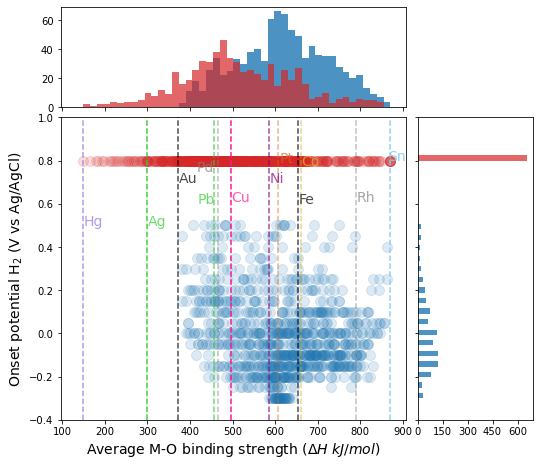

In [ ]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax1)
ax_histy = fig.add_axes(rect_histy, sharey=ax1)
kde_hist(df3["Ave M-O bond"],df3["Onset potential H2 Ag/AgCl"], ax1,
         ax_histx, ax_histy)

ax1.set_ylabel("Onset potential H$_2$ (V vs Ag/AgCl)",fontsize=14)
ax1.set_xlabel("Average M-O binding strength ($\Delta H\;kJ/mol$)",fontsize=14)
#plt.title('Onset of H$_2$ vs. Ave M-O bond energy',fontsize=16, fontweight="bold")

ax1.axvline(x=606.5,c='chocolate',linestyle='--',alpha=0.5)
ax1.annotate('Pt',(610,0.79),c='chocolate',fontsize=14,alpha=0.7)
ax1.axvline(x=466.1, c='grey',linestyle='--',alpha=0.5)
ax1.annotate('Pd',(415,0.75),c='grey',fontsize=14,alpha=0.7)
ax1.axvline(x=660.5, c='goldenrod',linestyle='--',alpha=0.5)
ax1.annotate('Co',(660.5,0.78),c='goldenrod',fontsize=14,alpha=0.9)
ax1.axvline(x=654, c='black',linestyle='--',alpha=0.7)
ax1.annotate('Fe',(656,0.6),c='black',fontsize=14,alpha=0.7)
ax1.axvline(x=870.5, c='skyblue',linestyle='--',alpha=0.9)
ax1.annotate('Sn',(865,0.8),c='skyblue',fontsize=14,alpha=0.9)
ax1.axvline(x=586.4, c='purple',linestyle='--',alpha=0.7)
ax1.annotate('Ni',(586.4,0.7),c='purple',fontsize=14,alpha=0.7)
ax1.axvline(x=457.3, c='limegreen',linestyle='--',alpha=0.7)
ax1.annotate('Pb',(417,0.6),c='limegreen',fontsize=14,alpha=0.7)
ax1.axvline(x=299.3, c='limegreen',linestyle='--',alpha=0.95)
ax1.annotate('Ag',(301,0.5),c='limegreen',fontsize=14,alpha=0.7)
ax1.axvline(x=496.5, c='deeppink',linestyle='--',alpha=1)
ax1.annotate('Cu',(496.5,0.61),c='deeppink',fontsize=14,alpha=0.7)
ax1.axvline(x=372.5, c='black',linestyle='--',alpha=0.7)
ax1.annotate('Au',(374,0.7),c='black',fontsize=14,alpha=0.7)
ax1.axvline(x=790.5, c='grey',linestyle='--',alpha=0.5)
ax1.annotate('Rh',(790.5,0.61),c='grey',fontsize=14,alpha=0.7)
ax1.axvline(x=149.1, c='mediumpurple',linestyle='--',alpha=0.7)
ax1.annotate('Hg',(150,0.5),c='mediumpurple',fontsize=14,alpha=0.7)

#ax1.set_xlim(-2.95,-2.4)
ax1.set_ylim(-0.4,1)
plt.savefig("Onset H2 vs Ave M-O bond energy", dpi=300, 
           bbox_inches="tight")
plt.show()

## Onset H2 vs ave work function

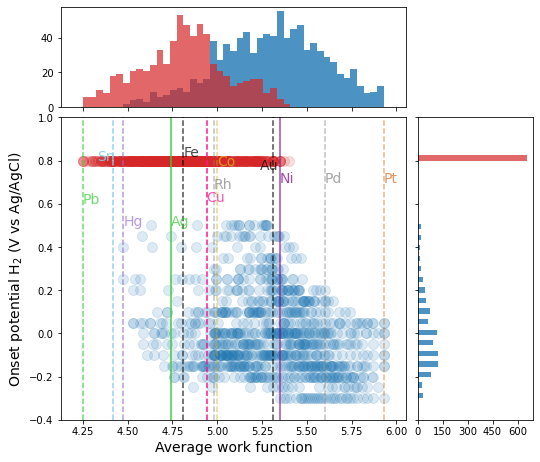

In [ ]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax1)
ax_histy = fig.add_axes(rect_histy, sharey=ax1)
kde_hist(df3["Ave work function"],df3["Onset potential H2 Ag/AgCl"], ax1,
         ax_histx, ax_histy)

ax1.set_ylabel("Onset potential H$_2$ (V vs Ag/AgCl)",fontsize=14)
ax1.set_xlabel("Average work function",fontsize=14)

ax1.axvline(x=5.93,c='chocolate',linestyle='--',alpha=0.5)
ax1.annotate('Pt',(5.93,0.7),c='chocolate',fontsize=14,alpha=0.7)
ax1.axvline(x=5.6, c='grey',linestyle='--',alpha=0.5)
ax1.annotate('Pd',(5.6,0.7),c='grey',fontsize=14,alpha=0.7)
ax1.axvline(x=5, c='goldenrod',linestyle='--',alpha=0.5)
ax1.annotate('Co',(5,0.78),c='goldenrod',fontsize=14,alpha=0.9)
ax1.axvline(x=4.81, c='black',linestyle='--',alpha=0.7)
ax1.annotate('Fe',(4.81,0.82),c='black',fontsize=14,alpha=0.7)
ax1.axvline(x=4.42, c='skyblue',linestyle='--',alpha=0.9)
ax1.annotate('Sn',(4.33,0.8),c='skyblue',fontsize=14,alpha=0.9)
ax1.axvline(x=5.35, c='purple',linestyle='-',alpha=0.7)
ax1.annotate('Ni',(5.35,0.7),c='purple',fontsize=14,alpha=0.7)
ax1.axvline(x=4.25, c='limegreen',linestyle='--',alpha=0.7)
ax1.annotate('Pb',(4.25,0.6),c='limegreen',fontsize=14,alpha=0.7)
ax1.axvline(x=4.74, c='limegreen',linestyle='-',alpha=0.95)
ax1.annotate('Ag',(4.74,0.5),c='limegreen',fontsize=14,alpha=0.7)
ax1.axvline(x=4.94, c='deeppink',linestyle='--',alpha=1)
ax1.annotate('Cu',(4.94,0.61),c='deeppink',fontsize=14,alpha=0.7)
ax1.axvline(x=5.31, c='black',linestyle='--',alpha=0.7)
ax1.annotate('Au',(5.24,0.76),c='black',fontsize=14,alpha=0.7)
ax1.axvline(x=4.98, c='grey',linestyle='--',alpha=0.5)
ax1.annotate('Rh',(4.98,0.67),c='grey',fontsize=14,alpha=0.7)
ax1.axvline(x=4.475, c='mediumpurple',linestyle='--',alpha=0.7)
ax1.annotate('Hg',(4.475,0.5),c='mediumpurple',fontsize=14,alpha=0.7)

#ax1.set_xlim(-2.95,-2.4)
ax1.set_ylim(-0.4,1)
plt.savefig("Onset H2 vs Ave work function", dpi=300, 
           bbox_inches="tight")
plt.show()

## Make a prediction array

In [ ]:
# Pass in the three elements you want to predict along with the fitted regressor model
# Only works for scikit-learn models
def plot_array(elements,regr):
  SID = []
  PCT = np.zeros((3,66))
  count = 0
  for i in range(11):
    for j in range(11-i):
      Sample_ID = elements[0] + str(i) + elements[1] + str(10-j-i) + elements[2] + str(j)
      SID.append(Sample_ID)
      PCT[:,count] = [i/10.0, (10-i-j)/10.0, j/10.0]
      count+=1
  temp = pd.Series(SID,name="Sample ID")
  temp2 = pd.DataFrame(PCT.T,index=temp.index,columns=["Percent A","Percent B","Percent C"])
  df = pd.concat((temp,temp2.astype("float")),axis=1)
  #print(df)
  row = []
  for i in range(66):
    row.append([])
    row[i].append(db.at[elements[0],"Atomic #"])
    row[i].append(db.at[elements[1],"Atomic #"])
    row[i].append(db.at[elements[2],"Atomic #"])
    row[i].append(float(db.at[elements[0],"Electronegativity"]))
    row[i].append(float(db.at[elements[1],"Electronegativity"]))
    row[i].append(float(db.at[elements[2],"Electronegativity"]))
    row[i].append(float(db.at[elements[0],"Reduction potential"]))
    row[i].append(float(db.at[elements[1],"Reduction potential"]))
    row[i].append(float(db.at[elements[2],"Reduction potential"]))
    row[i].append(db.at[elements[0],"Periodic group"])
    row[i].append(db.at[elements[1],"Periodic group"])
    row[i].append(db.at[elements[2],"Periodic group"])
    row[i].append(db.at[elements[0],"Electron configuration"])
    row[i].append(db.at[elements[1],"Electron configuration"])
    row[i].append(db.at[elements[2],"Electron configuration"])
    row[i].append(float(db.at[elements[0],"Ionization energy"]))
    row[i].append(float(db.at[elements[1],"Ionization energy"]))
    row[i].append(float(db.at[elements[2],"Ionization energy"]))
    row[i].append(float(db.at[elements[0],"Work function"]))
    row[i].append(float(db.at[elements[1],"Work function"]))
    row[i].append(float(db.at[elements[2],"Work function"]))
    row[i].append(db.at[elements[0],"Crystal structure"])
    row[i].append(db.at[elements[1],"Crystal structure"])
    row[i].append(db.at[elements[2],"Crystal structure"])
    row[i].append(float(db.at[elements[0],"Lattice spacing"]))
    row[i].append(float(db.at[elements[1],"Lattice spacing"]))
    row[i].append(float(db.at[elements[2],"Lattice spacing"]))
    row[i].append(float(db.at[elements[0],"H binding energy(eV)"]))
    row[i].append(float(db.at[elements[1],"H binding energy(eV)"]))
    row[i].append(float(db.at[elements[2],"H binding energy(eV)"]))
    row[i].append(float(db.at[elements[0],"M-O bond energy"]))
    row[i].append(float(db.at[elements[1],"M-O bond energy"]))
    row[i].append(float(db.at[elements[2],"M-O bond energy"]))
    row[i].append(float(db.at[elements[0],"OH binding energy(eV)"]))
    row[i].append(float(db.at[elements[1],"OH binding energy(eV)"]))
    row[i].append(float(db.at[elements[2],"OH binding energy(eV)"]))
  ROW = np.array(row)
  temp3 = pd.DataFrame(ROW,index=df.index,
                       columns=["Element A atomic #","Element B atomic #","Element C atomic #",
                                "Electronegativity of A","Electronegativity of B","Electronegativity of C",
                                "Reduction potential of A","Reduction potential of B","Reduction potential of C",
                                "Periodic group of A","Periodic group of B","Periodic group of C",
                                "Electron configuration of A","Electron configuration of B","Electron configuration of C",
                                "Ionization energy of A","Ionization energy of B","Ionization energy of C",
                                "Work function A","Work function B","Work function C",
                                "Crystal structure A","Crystal structure B","Crystal structure C",
                                "Lattice spacing A","Lattice spacing B","Lattice spacing C",
                                "H binding A","H binding B","H binding C",
                                "M-O bond strength A","M-O bond strength B","M-O bond strength C",
                                "OH binding A","OH binding B","OH binding C",])
  df5 = pd.concat((df,temp3),axis=1)
  df6 = one_hot(df5)
  df6["pct Ni"] = df6["Ais28"]*df6["Percent A"] + df6["Bis28"]*df6["Percent B"] + df6["Cis28"]*df6["Percent C"]
  df6["pct Cu"] = df6["Ais29"]*df6["Percent A"] + df6["Bis29"]*df6["Percent B"] + df6["Cis29"]*df6["Percent C"]
  df6["pct Pt"] = df6["Ais78"]*df6["Percent A"] + df6["Bis78"]*df6["Percent B"] + df6["Cis78"]*df6["Percent C"]
  df6["pct Ag"] = df6["Ais47"]*df6["Percent A"] + df6["Bis47"]*df6["Percent B"] + df6["Cis47"]*df6["Percent C"]
  df6["pct Pd"] = df6["Ais46"]*df6["Percent A"] + df6["Bis46"]*df6["Percent B"] + df6["Cis46"]*df6["Percent C"]
  df6["pct Co"] = df6["Ais27"]*df6["Percent A"] + df6["Bis27"]*df6["Percent B"] + df6["Cis27"]*df6["Percent C"]
  df6["pct Fe"] = df6["Ais26"]*df6["Percent A"] + df6["Bis26"]*df6["Percent B"] + df6["Cis26"]*df6["Percent C"]
  df6["pct Hg"] = df6["Ais80"]*df6["Percent A"] + df6["Bis80"]*df6["Percent B"] + df6["Cis80"]*df6["Percent C"]
  df6["pct Au"] = df6["Ais79"]*df6["Percent A"] + df6["Bis79"]*df6["Percent B"] + df6["Cis79"]*df6["Percent C"]
  df6["pct Rh"] = df6["Ais45"]*df6["Percent A"] + df6["Bis45"]*df6["Percent B"] + df6["Cis45"]*df6["Percent C"]
  df6["pct Sn"] = df6["Ais50"]*df6["Percent A"] + df6["Bis50"]*df6["Percent B"] + df6["Cis50"]*df6["Percent C"]
  df6["pct Pb"] = df6["Ais82"]*df6["Percent A"] + df6["Bis82"]*df6["Percent B"] + df6["Cis82"]*df6["Percent C"]
  df6["pct 14"] = df6["Ais14"]*df6["Percent A"] + df6["Bis14"]*df6["Percent B"] + df6["Cis14"]*df6["Percent C"]
  df6["pct 12"] = df6["Ais12"]*df6["Percent A"] + df6["Bis12"]*df6["Percent B"] + df6["Cis12"]*df6["Percent C"]
  df6["pct 11"] = df6["Ais11"]*df6["Percent A"] + df6["Bis11"]*df6["Percent B"] + df6["Cis11"]*df6["Percent C"]
  df6["pct 10"] = df6["Ais10"]*df6["Percent A"] + df6["Bis10"]*df6["Percent B"] + df6["Cis10"]*df6["Percent C"]
  df6["pct 9"] = df6["Ais9"]*df6["Percent A"] + df6["Bis9"]*df6["Percent B"] + df6["Cis9"]*df6["Percent C"]
  df6["pct 8"] = df6["Ais8"]*df6["Percent A"] + df6["Bis8"]*df6["Percent B"] + df6["Cis8"]*df6["Percent C"]
  df6["pctp2"] = df6["Aisp2"]*df6["Percent A"] + df6["Bisp2"]*df6["Percent B"] + df6["Cisp2"]*df6["Percent C"]
  df6["pctd10s2"] = df6["Aisd10s2"]*df6["Percent A"] + df6["Bisd10s2"]*df6["Percent B"] + df6["Cisd10s2"]*df6["Percent C"]
  df6["pctd10s1"] = df6["Aisd10s1"]*df6["Percent A"] + df6["Bisd10s1"]*df6["Percent B"] + df6["Cisd10s1"]*df6["Percent C"]
  df6["pctd9s1"] = df6["Aisd9s1"]*df6["Percent A"] + df6["Bisd9s1"]*df6["Percent B"] + df6["Cisd9s1"]*df6["Percent C"]
  df6["pctd10s0"] = df6["Aisd10s0"]*df6["Percent A"] + df6["Bisd10s0"]*df6["Percent B"] + df6["Cisd10s0"]*df6["Percent C"]
  df6["pctd7s2"] = df6["Aisd7s2"]*df6["Percent A"] + df6["Bisd7s2"]*df6["Percent B"] + df6["Cisd7s2"]*df6["Percent C"]
  df6["pctd6s2"] = df6["Aisd6s2"]*df6["Percent A"] + df6["Bisd6s2"]*df6["Percent B"] + df6["Cisd6s2"]*df6["Percent C"]
  df6["pctd8s2"] = df6["Aisd8s2"]*df6["Percent A"] + df6["Bisd8s2"]*df6["Percent B"] + df6["Cisd8s2"]*df6["Percent C"]
  df6["pctd8s1"] = df6["Aisd8s1"]*df6["Percent A"] + df6["Bisd8s1"]*df6["Percent B"] + df6["Cisd8s1"]*df6["Percent C"]
  df6["pctfcc"] = df6["Aisfcc"]*df6["Percent A"] + df6["Bisfcc"]*df6["Percent B"] + df6["Cisfcc"]*df6["Percent C"]
  df6["pcthex"] = df6["Aishex"]*df6["Percent A"] + df6["Bishex"]*df6["Percent B"] + df6["Cishex"]*df6["Percent C"]
  df6["pcttet"] = df6["Aistet"]*df6["Percent A"] + df6["Bistet"]*df6["Percent B"] + df6["Cistet"]*df6["Percent C"]
  df6["pctbcc"] = df6["Aisbcc"]*df6["Percent A"] + df6["Bisbcc"]*df6["Percent B"] + df6["Cisbcc"]*df6["Percent C"]
  df6["Ave ion energy"] = (df6["Ionization energy of A"].astype('float')*df6["Percent A"].astype('float') 
                           + df6["Ionization energy of B"].astype('float')*df6["Percent B"].astype('float') 
                           + df6["Ionization energy of C"].astype('float')*df6["Percent C"].astype('float'))
  df6["Ave electronegativity"] = (df6["Electronegativity of A"].astype('float')*df6["Percent A"].astype('float') + 
                                  df6["Electronegativity of B"].astype('float')*df6["Percent B"].astype('float') + 
                                  df6["Electronegativity of C"].astype('float')*df6["Percent C"].astype('float'))
  df6["Ave reduction potential"] = (df6["Reduction potential of A"].astype('float')*df6["Percent A"].astype('float') + 
                                  df6["Reduction potential of B"].astype('float')*df6["Percent B"].astype('float') + 
                                  df6["Reduction potential of C"].astype('float')*df6["Percent C"].astype('float'))
  df6["Ave work function"] = (df6["Work function A"].astype("float")*df6["Percent A"] + 
                                  df6["Work function B"].astype("float")*df6["Percent B"] + 
                                  df6["Work function C"].astype("float")*df6["Percent C"])
  df6["Ave lattice spacing"] = (df6["Lattice spacing A"].astype("float")*df6["Percent A"] + 
                                  df6["Lattice spacing B"].astype("float")*df6["Percent B"] + 
                                  df6["Lattice spacing C"].astype("float")*df6["Percent C"])
  df6["Ave H binding"] = (df6["H binding A"].astype("float")*df6["Percent A"] + 
                                  df6["H binding B"].astype("float")*df6["Percent B"] + 
                                  df6["H binding C"].astype("float")*df6["Percent C"])
  df6["Ave OH binding"] = (df6["OH binding A"].astype("float")*df6["Percent A"] + 
                                  df6["OH binding B"].astype("float")*df6["Percent B"] + 
                                  df6["OH binding C"].astype("float")*df6["Percent C"])
  df6["Ave M-O bond"] = (df6["M-O bond strength A"].astype("float")*df6["Percent A"] + 
                                  df6["M-O bond strength B"].astype("float")*df6["Percent B"] + 
                                  df6["M-O bond strength C"].astype("float")*df6["Percent C"])
  columns = ["pct Ni","pct Cu","pct Pt","pct Ag","pct Pd","pct Co","pct Fe","pct Hg","pct Au",
             "pct Rh","pct Sn","pct Pb","pct 14","pct 12","pct 11","pct 10","pct 9","pct 8",
             "pctp2","pctd10s2","pctd10s1","pctd9s1","pctd10s0","pctd7s2","pctd6s2",
             "pctd8s2","pctd8s1","pctfcc","pcthex","pcttet","pctbcc",
             "Ave ion energy","Ave electronegativity","Ave reduction potential","Ave work function",
             "Ave lattice spacing","Ave H binding","Ave OH binding","Ave M-O bond"]
  

  df6 = rescale(df6)
  df6.drop(["Sample ID","Element A atomic #","Element B atomic #",
              "Element C atomic #","Periodic group of A","Periodic group of B","Periodic group of C",
              "Electron configuration of A","Electron configuration of B","Electron configuration of C",
              "Electronegativity of A","Electronegativity of B","Electronegativity of C",
              "Reduction potential of A","Reduction potential of B","Reduction potential of C",
              "Ionization energy of A","Ionization energy of B","Ionization energy of C",
              "Crystal structure A","Crystal structure B","Crystal structure C",'Ais78', 'Ais46', 'Ais27',
              'Ais26', 'Ais25', 'Ais77', 'Ais28', 'Ais29', 'Ais47', 'Ais79', 'Ais45', 'Ais24','Ais50',
              'Ais82','Ais80', 'Bis78', 'Bis46','Bis27', 'Bis26', 'Bis25', 'Bis77', 'Bis28', 'Bis29',
              'Bis47', 'Bis79', 'Bis45', 'Bis24','Bis50','Bis82','Bis80','Cis78','Cis46', 'Cis27', 'Cis26',
              'Cis25', 'Cis77', 'Cis28', 'Cis29', 'Cis47', 'Cis79', 'Cis45', 'Cis24','Cis50','Cis82',
              'Cis80','Aisd9s1', 'Aisd10s0', 'Aisd7s2', 'Aisd6s2', 'Aisd8s2', 'Aisd10s1', 'Aisd8s1',
              'Aisd5s1','Aisp2','Aisd10s2','Bisd9s1', 'Bisd10s0', 'Bisd7s2', 'Bisd6s2', 'Bisd8s2',
              'Bisd10s1', 'Bisd8s1', 'Bisd5s1','Bisp2','Bisd10s2','Cisd9s1', 'Cisd10s0', 'Cisd7s2',
              'Cisd6s2', 'Cisd8s2', 'Cisd10s1', 'Cisd8s1', 'Cisd5s1','Cisp2','Cisd10s2','Aisfcc','Aishex',
              'Aisbcc', 'Aiscub','Aistet', 'Bisfcc', 'Bishex','Bisbcc', 'Biscub','Bistet','Cisfcc', 'Cishex', 'Cisbcc',
              'Ciscub','Cistet','Percent A', 'Percent B', 'Percent C', 'Work function A','Work function B',
              'Work function C', 'Lattice spacing A','Lattice spacing B', 'Lattice spacing C',
              'H binding A','H binding B','H binding C','Ais11','Ais10','Ais9','Ais8','Ais7','Ais6',
              'Ais12', 'Ais14','Bis11','Bis10','Bis9','Bis8','Bis7','Bis6','Bis12','Bis14','Cis11','Cis10',
              'Cis9','Cis8','Cis7','Cis6','Cis12','Cis14','M-O bond strength A','M-O bond strength B',
              'M-O bond strength C','OH binding A','OH binding B','OH binding C'],axis=1,inplace=True)
  for col in df6.columns:
    if df6[col].isnull().all():
      df6[col] = np.ones(len(df6))
  poly = PolynomialFeatures(2,interaction_only=True)
  df7 = poly.fit_transform(df6)
  y_predict = regr.predict(df7)
  #print(y_predict)
  array = pd.concat((df6.iloc[:,:3],pd.DataFrame(y_predict,index=df6.index,columns=["value"])),axis=1)
  fig = px.scatter_ternary(temp2, a="Percent A", b="Percent B", c="Percent C", range_color=[-0.2,1],
      color=y_predict,size=6*(y_predict+300), size_max=16, 
      color_continuous_scale=["yellow","greenyellow","cornflowerblue","indigo","black"])
  fig.show()
  df["Onset potential H2 Ag/AgCl"] = y_predict
  df.to_excel('{}.xls'.format(elements[0]+elements[1]+elements[2]))
  return y_predict

alloy = ["Co","Ni","Pt"]
ard_predict = plot_array(alloy,regr_ard)
#nn_predict = plot_array(alloy,regr_nn)
#tree_predict = plot_array(alloy,regr_GB)


C:\Users\Jeremy\AppData\Local\Temp/ipykernel_5520/3509680263.py:492: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\Jeremy\AppData\Local\Temp/ipykernel_5520/3509680263.py:494: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\Jeremy\AppData\Local\Temp/ipykernel_5520/3509680263.py:495: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fr

C:\Users\Jeremy\AppData\Local\Temp/ipykernel_5520/3854587399.py:183: FutureWarning:

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.



## Model aggregation

In [ ]:
# make a prediction from all three models use them to train a linear model
# to make predictions
# This part of the code was not finalized and may not run correctly
def model_vote(y_predict_train_nn,y_predict_train_tree,y_predict_train_ard,y_train,y_test):
  predictions = pd.DataFrame((y_predict_train_nn,y_predict_train_tree,y_predict_train_ard))
  print(y_predict_train_ard.shape)
  voter = LinearRegression()
  voter.fit(predictions.transpose(), y_train)
  y_predict_test_all = pd.DataFrame((y_predict_test_nn,y_predict_test_tree,y_predict_test_ard))
  final_vote_train = voter.predict(predictions.transpose())
  final_vote_test = voter.predict(y_predict_test_all.transpose())
  test_score_vote = voter.score(y_predict_test_all.transpose(), final_vote_test)
  train_score_vote = voter.score(predictions.transpose(), final_vote_train)

  fig = plt.figure(figsize=(8, 8))
  ax = fig.add_axes(rect_scatter)
  ax_histx = fig.add_axes(rect_histx, sharex=ax)
  ax_histy = fig.add_axes(rect_histy, sharey=ax)
  scatter_hist(final_vote_test, y_test, final_vote_train, y_train, ax, ax_histx, ax_histy)
  ax.annotate('RMSE = {:.2}'.format(mean_squared_error(y_test,final_vote_test,squared=False)),
              (-0.05,0.95),fontsize=14,color='blue',alpha=0.7)
  ax.annotate('R$^2$ = {:.2}'.format(test_score_vote),
              (-0.05,1.0),fontsize=14,color='blue',alpha=0.7)
  ax.annotate('RMSE = {:.2}'.format(mean_squared_error(y_train,final_vote_train,squared=False)),
              (0.28,0.95),fontsize=14,color='red',alpha=0.7)
  ax.annotate('R$^2$ = {:.2}'.format(train_score_vote),
              (0.28,1.0),fontsize=14,color='red',alpha=0.7)
  ax.set_xlabel("Predicted value")
  ax.set_ylabel("True value")
  #print('R$^2$ = {:.2}'.format(score))
  #print('RMSE = {:.3}'.format(mean_squared_error(y_test,y_predict,squared=False)))
  plt.savefig("Results from linear model with H2", dpi=300, 
              bbox_inches="tight")
  return voter


Voter = model_vote(y_predict_train_nn,y_predict_train_tree,y_predict_train_ard,y_train,y_test)
Voter.coef_

In [ ]:
temp = pd.DataFrame((nn_predict,tree_predict,ard_predict))
New_predict = Voter.predict(temp.transpose())
New_predict = 0.25*nn_predict + 0.6*tree_predict + 0.15*ard_predict
title = alloy[0] + alloy[1] + alloy[2]
fig = px.scatter_ternary(df2[:66],a="Percent A", b="Percent B", c="Percent C", range_color=[-0.15,1.0],
        color=New_predict,size=6*(New_predict+2.5), size_max=16, 
        color_continuous_scale=["red","orange","yellow","greenyellow","cornflowerblue"],title=title)
fig.show()
#fig.write_image('Prediction of onset potential {}.svg'.format("PtPdCu"))

## SI plot

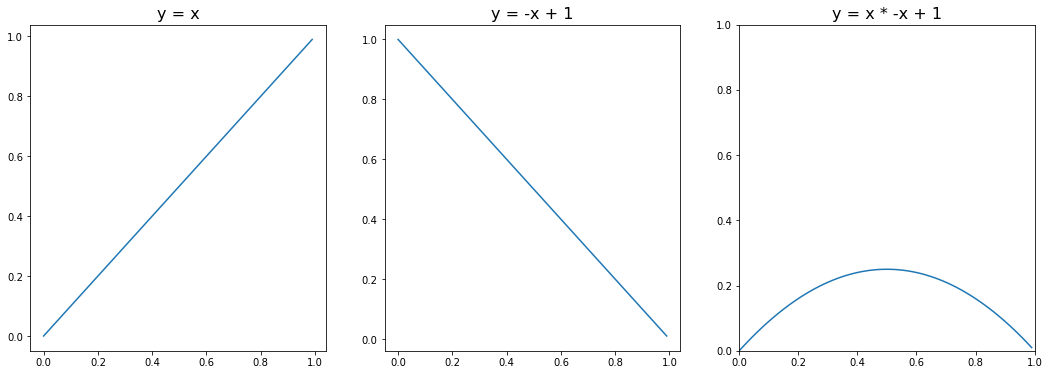

In [ ]:
x = np.arange(0,1,0.01)
fig, axs = plt.subplots(1,3,figsize=(18, 6))
axs[0].plot(x,x)
axs[0].set_title('y = x',fontsize=16)
axs[1].plot(x,-1*x+1)
axs[1].set_title('y = -x + 1',fontsize=16)
axs[2].plot(x,x*(-1*x+1))
axs[2].set_title('y = x * -x + 1',fontsize=16)
axs[2].set_xlim(0,1)
axs[2].set_ylim(0,1)
plt.savefig("poly feature demo.png",dpi=300)
plt.show()